In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

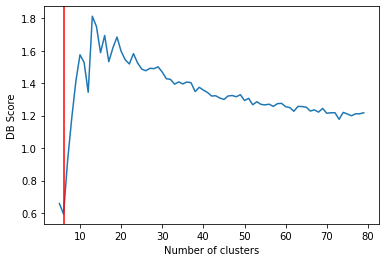

{0, 1, 2, 3, 4, 5}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

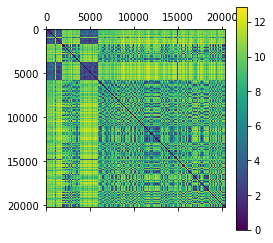

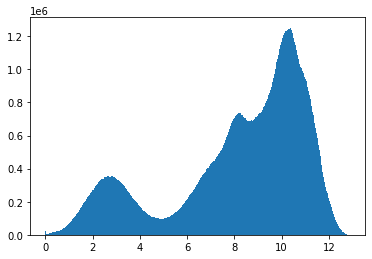

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

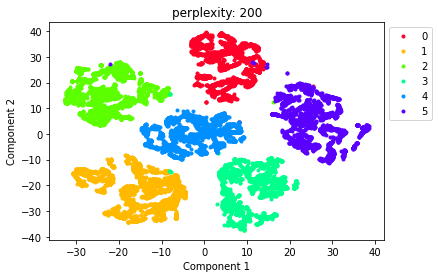

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9911792243630808


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.1643416881342385
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.3708563535911602
layer 7: 0.23178522099447513
layer 8: 0.1429342196132597
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.788 | Reg loss: 0.016 | Tree loss: 1.788 | Accuracy: 0.188500 | 3.328 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.772 | Reg loss: 0.016 | Tree loss: 1.772 | Accuracy: 0.185000 | 2.29 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.761 | Reg loss: 0.016 | Tree loss: 1.761 | Accuracy: 0.350000 | 1.916 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.745 | Reg loss: 0.015 | Tree loss: 1.745 | Accuracy: 0.465000 | 1.702 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.735 | Reg loss: 0.015 | Tree loss: 1.735 | Accuracy: 0.480500 | 1.573 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.015 | Tree loss: 1.723 | Accu

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.728 | Reg loss: 0.013 | Tree loss: 1.728 | Accuracy: 0.481000 | 1.519 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.713 | Reg loss: 0.013 | Tree loss: 1.713 | Accuracy: 0.478000 | 1.515 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 1.688 | Reg loss: 0.013 | Tree loss: 1.688 | Accuracy: 0.496500 | 1.509 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 1.666 | Reg loss: 0.014 | Tree loss: 1.666 | Accuracy: 0.508500 | 1.501 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 1.637 | Reg loss: 0.014 | Tree loss: 1.637 | Accuracy: 0.547500 | 1.494 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 1.611 | Reg loss: 0.014 | Tree loss: 1.611 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 1.627 | Reg loss: 0.016 | Tree loss: 1.627 | Accuracy: 0.608000 | 1.496 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 1.592 | Reg loss: 0.017 | Tree loss: 1.592 | Accuracy: 0.598500 | 1.494 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 1.548 | Reg loss: 0.017 | Tree loss: 1.548 | Accuracy: 0.575500 | 1.491 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 1.498 | Reg loss: 0.017 | Tree loss: 1.498 | Accuracy: 0.564000 | 1.488 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 1.449 | Reg loss: 0.017 | Tree loss: 1.449 | Accuracy: 0.587000 | 1.484 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 1.422 | Reg loss: 0.017 | Tree loss: 1.422 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 1.466 | Reg loss: 0.019 | Tree loss: 1.466 | Accuracy: 0.632000 | 1.493 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 1.411 | Reg loss: 0.019 | Tree loss: 1.411 | Accuracy: 0.629000 | 1.49 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 1.376 | Reg loss: 0.020 | Tree loss: 1.376 | Accuracy: 0.612000 | 1.486 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 1.310 | Reg loss: 0.020 | Tree loss: 1.310 | Accuracy: 0.646500 | 1.483 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 1.264 | Reg loss: 0.020 | Tree loss: 1.264 | Accuracy: 0.629500 | 1.48 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 1.214 | Reg loss: 0.020 | Tree loss: 1.214 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 1.312 | Reg loss: 0.022 | Tree loss: 1.312 | Accuracy: 0.658500 | 1.506 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 1.245 | Reg loss: 0.022 | Tree loss: 1.245 | Accuracy: 0.684500 | 1.504 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 1.178 | Reg loss: 0.022 | Tree loss: 1.178 | Accuracy: 0.710500 | 1.503 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 1.135 | Reg loss: 0.022 | Tree loss: 1.135 | Accuracy: 0.735500 | 1.501 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 1.066 | Reg loss: 0.022 | Tree loss: 1.066 | Accuracy: 0.737500 | 1.499 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 1.039 | Reg loss: 0.022 | Tree loss: 1.039 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 1.183 | Reg loss: 0.023 | Tree loss: 1.183 | Accuracy: 0.703000 | 1.5 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 1.113 | Reg loss: 0.023 | Tree loss: 1.113 | Accuracy: 0.720000 | 1.499 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 1.058 | Reg loss: 0.023 | Tree loss: 1.058 | Accuracy: 0.749000 | 1.498 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 0.996 | Reg loss: 0.023 | Tree loss: 0.996 | Accuracy: 0.765000 | 1.496 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 0.944 | Reg loss: 0.023 | Tree loss: 0.944 | Accuracy: 0.764500 | 1.495 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 0.899 | Reg loss: 0.024 | Tree loss: 0.899 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 1.071 | Reg loss: 0.024 | Tree loss: 1.071 | Accuracy: 0.721000 | 1.496 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 1.025 | Reg loss: 0.024 | Tree loss: 1.025 | Accuracy: 0.721500 | 1.495 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 0.948 | Reg loss: 0.024 | Tree loss: 0.948 | Accuracy: 0.732000 | 1.494 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 0.902 | Reg loss: 0.025 | Tree loss: 0.902 | Accuracy: 0.743000 | 1.493 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 0.859 | Reg loss: 0.025 | Tree loss: 0.859 | Accuracy: 0.754000 | 1.492 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 0.831 | Reg loss: 0.025 | Tree loss: 0.831 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 0.948 | Reg loss: 0.025 | Tree loss: 0.948 | Accuracy: 0.755000 | 1.494 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 0.941 | Reg loss: 0.025 | Tree loss: 0.941 | Accuracy: 0.741500 | 1.493 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 0.883 | Reg loss: 0.025 | Tree loss: 0.883 | Accuracy: 0.774000 | 1.492 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 0.841 | Reg loss: 0.025 | Tree loss: 0.841 | Accuracy: 0.777500 | 1.491 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 0.794 | Reg loss: 0.025 | Tree loss: 0.794 | Accuracy: 0.794500 | 1.49 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 0.761 | Reg loss: 0.025 | Tree loss: 0.761 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 0.898 | Reg loss: 0.026 | Tree loss: 0.898 | Accuracy: 0.740500 | 1.484 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 0.852 | Reg loss: 0.026 | Tree loss: 0.852 | Accuracy: 0.762500 | 1.483 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 0.808 | Reg loss: 0.026 | Tree loss: 0.808 | Accuracy: 0.770000 | 1.482 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 0.778 | Reg loss: 0.026 | Tree loss: 0.778 | Accuracy: 0.781000 | 1.481 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 0.721 | Reg loss: 0.026 | Tree loss: 0.721 | Accuracy: 0.806500 | 1.48 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 0.693 | Reg loss: 0.026 | Tree loss: 0.693 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 0.840 | Reg loss: 0.027 | Tree loss: 0.840 | Accuracy: 0.751500 | 1.452 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 0.826 | Reg loss: 0.027 | Tree loss: 0.826 | Accuracy: 0.735500 | 1.452 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 0.767 | Reg loss: 0.027 | Tree loss: 0.767 | Accuracy: 0.773500 | 1.451 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 0.742 | Reg loss: 0.027 | Tree loss: 0.742 | Accuracy: 0.775500 | 1.45 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 0.702 | Reg loss: 0.027 | Tree loss: 0.702 | Accuracy: 0.800500 | 1.449 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 0.689 | Reg loss: 0.027 | Tree loss: 0.689 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 50 | Batch: 000 / 011 | Total loss: 0.799 | Reg loss: 0.027 | Tree loss: 0.799 | Accuracy: 0.763000 | 1.433 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 0.747 | Reg loss: 0.027 | Tree loss: 0.747 | Accuracy: 0.767500 | 1.432 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 0.726 | Reg loss: 0.027 | Tree loss: 0.726 | Accuracy: 0.779000 | 1.432 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 0.695 | Reg loss: 0.027 | Tree loss: 0.695 | Accuracy: 0.776000 | 1.43 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 0.645 | Reg loss: 0.027 | Tree loss: 0.645 | Accuracy: 0.806000 | 1.429 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 0.614 | Reg loss: 0.027 | Tree loss: 0.614 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 55 | Batch: 000 / 011 | Total loss: 0.755 | Reg loss: 0.027 | Tree loss: 0.755 | Accuracy: 0.765500 | 1.415 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 0.715 | Reg loss: 0.027 | Tree loss: 0.715 | Accuracy: 0.772000 | 1.415 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 0.693 | Reg loss: 0.027 | Tree loss: 0.693 | Accuracy: 0.789000 | 1.414 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 0.658 | Reg loss: 0.027 | Tree loss: 0.658 | Accuracy: 0.811000 | 1.413 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 0.628 | Reg loss: 0.027 | Tree loss: 0.628 | Accuracy: 0.816000 | 1.413 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 0.609 | Reg loss: 0.027 | Tree loss: 0.609 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 60 | Batch: 000 / 011 | Total loss: 0.729 | Reg loss: 0.027 | Tree loss: 0.729 | Accuracy: 0.765500 | 1.393 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 0.706 | Reg loss: 0.027 | Tree loss: 0.706 | Accuracy: 0.776000 | 1.392 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 0.648 | Reg loss: 0.027 | Tree loss: 0.648 | Accuracy: 0.802500 | 1.391 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 0.624 | Reg loss: 0.027 | Tree loss: 0.624 | Accuracy: 0.816000 | 1.391 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 0.596 | Reg loss: 0.027 | Tree loss: 0.596 | Accuracy: 0.819500 | 1.39 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 0.567 | Reg loss: 0.027 | Tree loss: 0.567 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 65 | Batch: 000 / 011 | Total loss: 0.706 | Reg loss: 0.028 | Tree loss: 0.706 | Accuracy: 0.770500 | 1.374 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 0.688 | Reg loss: 0.028 | Tree loss: 0.688 | Accuracy: 0.782500 | 1.373 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 0.631 | Reg loss: 0.028 | Tree loss: 0.631 | Accuracy: 0.799500 | 1.373 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 0.641 | Reg loss: 0.028 | Tree loss: 0.641 | Accuracy: 0.795500 | 1.372 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 0.599 | Reg loss: 0.028 | Tree loss: 0.599 | Accuracy: 0.815500 | 1.372 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 0.567 | Reg loss: 0.028 | Tree loss: 0.567 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 70 | Batch: 000 / 011 | Total loss: 0.692 | Reg loss: 0.028 | Tree loss: 0.692 | Accuracy: 0.781000 | 1.357 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 0.671 | Reg loss: 0.028 | Tree loss: 0.671 | Accuracy: 0.792000 | 1.357 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 0.606 | Reg loss: 0.028 | Tree loss: 0.606 | Accuracy: 0.823000 | 1.356 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 0.593 | Reg loss: 0.028 | Tree loss: 0.593 | Accuracy: 0.817500 | 1.356 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 0.560 | Reg loss: 0.028 | Tree loss: 0.560 | Accuracy: 0.820500 | 1.355 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 0.553 | Reg loss: 0.028 | Tree loss: 0.553 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 75 | Batch: 000 / 011 | Total loss: 0.684 | Reg loss: 0.028 | Tree loss: 0.684 | Accuracy: 0.774000 | 1.343 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 0.642 | Reg loss: 0.028 | Tree loss: 0.642 | Accuracy: 0.800000 | 1.343 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 0.613 | Reg loss: 0.028 | Tree loss: 0.613 | Accuracy: 0.816000 | 1.342 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 0.614 | Reg loss: 0.028 | Tree loss: 0.614 | Accuracy: 0.803000 | 1.342 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 0.574 | Reg loss: 0.028 | Tree loss: 0.574 | Accuracy: 0.816000 | 1.341 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 0.528 | Reg loss: 0.028 | Tree loss: 0.528 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 80 | Batch: 000 / 011 | Total loss: 0.659 | Reg loss: 0.028 | Tree loss: 0.659 | Accuracy: 0.781000 | 1.333 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 0.634 | Reg loss: 0.028 | Tree loss: 0.634 | Accuracy: 0.795500 | 1.332 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 0.595 | Reg loss: 0.028 | Tree loss: 0.595 | Accuracy: 0.818000 | 1.332 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 0.587 | Reg loss: 0.028 | Tree loss: 0.587 | Accuracy: 0.823500 | 1.331 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 0.545 | Reg loss: 0.028 | Tree loss: 0.545 | Accuracy: 0.838500 | 1.331 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 0.533 | Reg loss: 0.028 | Tree loss: 0.533 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 85 | Batch: 000 / 011 | Total loss: 0.667 | Reg loss: 0.028 | Tree loss: 0.667 | Accuracy: 0.776500 | 1.324 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 0.641 | Reg loss: 0.028 | Tree loss: 0.641 | Accuracy: 0.804000 | 1.323 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 0.593 | Reg loss: 0.028 | Tree loss: 0.593 | Accuracy: 0.823500 | 1.323 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 0.559 | Reg loss: 0.028 | Tree loss: 0.559 | Accuracy: 0.842000 | 1.323 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 0.526 | Reg loss: 0.028 | Tree loss: 0.526 | Accuracy: 0.842000 | 1.322 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 0.529 | Reg loss: 0.028 | Tree loss: 0.529 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 90 | Batch: 000 / 011 | Total loss: 0.638 | Reg loss: 0.028 | Tree loss: 0.638 | Accuracy: 0.793000 | 1.314 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 0.628 | Reg loss: 0.028 | Tree loss: 0.628 | Accuracy: 0.806500 | 1.313 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 0.591 | Reg loss: 0.028 | Tree loss: 0.591 | Accuracy: 0.812500 | 1.313 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 0.557 | Reg loss: 0.028 | Tree loss: 0.557 | Accuracy: 0.832500 | 1.313 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 0.540 | Reg loss: 0.028 | Tree loss: 0.540 | Accuracy: 0.829000 | 1.312 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 0.507 | Reg loss: 0.028 | Tree loss: 0.507 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 95 | Batch: 000 / 011 | Total loss: 0.627 | Reg loss: 0.028 | Tree loss: 0.627 | Accuracy: 0.804000 | 1.305 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 0.623 | Reg loss: 0.028 | Tree loss: 0.623 | Accuracy: 0.804500 | 1.305 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 0.570 | Reg loss: 0.028 | Tree loss: 0.570 | Accuracy: 0.825500 | 1.304 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 0.538 | Reg loss: 0.028 | Tree loss: 0.538 | Accuracy: 0.837500 | 1.304 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 0.520 | Reg loss: 0.029 | Tree loss: 0.520 | Accuracy: 0.843000 | 1.304 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 0.520 | Reg loss: 0.029 | Tree loss: 0.520 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 100 | Batch: 000 / 011 | Total loss: 0.629 | Reg loss: 0.029 | Tree loss: 0.629 | Accuracy: 0.811500 | 1.297 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 0.598 | Reg loss: 0.029 | Tree loss: 0.598 | Accuracy: 0.816000 | 1.297 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 0.575 | Reg loss: 0.029 | Tree loss: 0.575 | Accuracy: 0.812500 | 1.296 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 0.557 | Reg loss: 0.029 | Tree loss: 0.557 | Accuracy: 0.828500 | 1.296 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 0.514 | Reg loss: 0.029 | Tree loss: 0.514 | Accuracy: 0.842500 | 1.296 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 0.499 | Reg loss: 0.029 | Tree loss: 0.4

Epoch: 104 | Batch: 010 / 011 | Total loss: 0.493 | Reg loss: 0.029 | Tree loss: 0.493 | Accuracy: 0.860068 | 1.289 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 105 | Batch: 000 / 011 | Total loss: 0.610 | Reg loss: 0.029 | Tree loss: 0.610 | Accuracy: 0.808000 | 1.29 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 0.595 | Reg loss: 0.029 | Tree loss: 0.595 | Accuracy: 0.808500 | 1.29 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 0.557 | Reg loss: 0.029 | Tree loss: 0.557 | Accuracy: 0.822500 | 1.289 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 0.530 | Reg loss: 0.029 | Tree loss: 0.530 | Accuracy: 0.834500 | 1.289 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 0.534 | Reg loss: 0.029 | Tree loss: 0.534

Epoch: 109 | Batch: 009 / 011 | Total loss: 0.481 | Reg loss: 0.029 | Tree loss: 0.481 | Accuracy: 0.859500 | 1.285 sec/iter
Epoch: 109 | Batch: 010 / 011 | Total loss: 0.450 | Reg loss: 0.029 | Tree loss: 0.450 | Accuracy: 0.873720 | 1.285 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 110 | Batch: 000 / 011 | Total loss: 0.591 | Reg loss: 0.029 | Tree loss: 0.591 | Accuracy: 0.822000 | 1.285 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 0.582 | Reg loss: 0.029 | Tree loss: 0.582 | Accuracy: 0.807000 | 1.285 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 0.563 | Reg loss: 0.029 | Tree loss: 0.563 | Accuracy: 0.815500 | 1.284 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.5

Epoch: 114 | Batch: 008 / 011 | Total loss: 0.459 | Reg loss: 0.029 | Tree loss: 0.459 | Accuracy: 0.864500 | 1.28 sec/iter
Epoch: 114 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.029 | Tree loss: 0.464 | Accuracy: 0.866500 | 1.28 sec/iter
Epoch: 114 | Batch: 010 / 011 | Total loss: 0.466 | Reg loss: 0.029 | Tree loss: 0.466 | Accuracy: 0.870307 | 1.28 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 115 | Batch: 000 / 011 | Total loss: 0.601 | Reg loss: 0.029 | Tree loss: 0.601 | Accuracy: 0.813500 | 1.282 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.578 | Reg loss: 0.029 | Tree loss: 0.578 | Accuracy: 0.826000 | 1.282 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.542 

Epoch: 119 | Batch: 007 / 011 | Total loss: 0.485 | Reg loss: 0.029 | Tree loss: 0.485 | Accuracy: 0.843500 | 1.298 sec/iter
Epoch: 119 | Batch: 008 / 011 | Total loss: 0.457 | Reg loss: 0.029 | Tree loss: 0.457 | Accuracy: 0.864000 | 1.298 sec/iter
Epoch: 119 | Batch: 009 / 011 | Total loss: 0.472 | Reg loss: 0.029 | Tree loss: 0.472 | Accuracy: 0.861500 | 1.298 sec/iter
Epoch: 119 | Batch: 010 / 011 | Total loss: 0.479 | Reg loss: 0.029 | Tree loss: 0.479 | Accuracy: 0.870307 | 1.298 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.598 | Reg loss: 0.029 | Tree loss: 0.598 | Accuracy: 0.809000 | 1.299 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.563 | Reg loss: 0.029 | Tree loss: 0.5

Epoch: 124 | Batch: 006 / 011 | Total loss: 0.477 | Reg loss: 0.029 | Tree loss: 0.477 | Accuracy: 0.854500 | 1.308 sec/iter
Epoch: 124 | Batch: 007 / 011 | Total loss: 0.471 | Reg loss: 0.030 | Tree loss: 0.471 | Accuracy: 0.846500 | 1.308 sec/iter
Epoch: 124 | Batch: 008 / 011 | Total loss: 0.481 | Reg loss: 0.030 | Tree loss: 0.481 | Accuracy: 0.852000 | 1.308 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.482 | Reg loss: 0.030 | Tree loss: 0.482 | Accuracy: 0.850000 | 1.308 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.030 | Tree loss: 0.461 | Accuracy: 0.877133 | 1.308 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.590 | Reg loss: 0.029 | Tree loss: 0.5

Epoch: 129 | Batch: 005 / 011 | Total loss: 0.485 | Reg loss: 0.030 | Tree loss: 0.485 | Accuracy: 0.840000 | 1.313 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.476 | Reg loss: 0.030 | Tree loss: 0.476 | Accuracy: 0.848500 | 1.313 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.481 | Reg loss: 0.030 | Tree loss: 0.481 | Accuracy: 0.844500 | 1.313 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.448 | Reg loss: 0.030 | Tree loss: 0.448 | Accuracy: 0.856000 | 1.313 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.463 | Reg loss: 0.030 | Tree loss: 0.463 | Accuracy: 0.857500 | 1.313 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.481 | Reg loss: 0.030 | Tree loss: 0.481 | Accuracy: 0.843003 | 1.313 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 134 | Batch: 004 / 011 | Total loss: 0.496 | Reg loss: 0.030 | Tree loss: 0.496 | Accuracy: 0.840000 | 1.326 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.476 | Reg loss: 0.030 | Tree loss: 0.476 | Accuracy: 0.856500 | 1.326 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.473 | Reg loss: 0.030 | Tree loss: 0.473 | Accuracy: 0.857500 | 1.326 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.455 | Reg loss: 0.030 | Tree loss: 0.455 | Accuracy: 0.858000 | 1.326 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.469 | Reg loss: 0.030 | Tree loss: 0.469 | Accuracy: 0.860000 | 1.326 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.459 | Reg loss: 0.030 | Tree loss: 0.459 | Accuracy: 0.870500 | 1.326 sec/iter
Epoch: 134 | Batch: 010 / 011 | Total loss: 0.449 | Reg loss: 0.030 | Tree loss: 0.449 | Accuracy: 0.853242 | 1.327 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 139 | Batch: 003 / 011 | Total loss: 0.518 | Reg loss: 0.030 | Tree loss: 0.518 | Accuracy: 0.840500 | 1.331 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.493 | Reg loss: 0.030 | Tree loss: 0.493 | Accuracy: 0.839000 | 1.331 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.487 | Reg loss: 0.030 | Tree loss: 0.487 | Accuracy: 0.839000 | 1.332 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.461 | Reg loss: 0.030 | Tree loss: 0.461 | Accuracy: 0.857000 | 1.332 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.466 | Reg loss: 0.030 | Tree loss: 0.466 | Accuracy: 0.855500 | 1.332 sec/iter
Epoch: 139 | Batch: 008 / 011 | Total loss: 0.457 | Reg loss: 0.030 | Tree loss: 0.457 | Accuracy: 0.867500 | 1.333 sec/iter
Epoch: 139 | Batch: 009 / 011 | Total loss: 0.464 | Reg loss: 0.030 | Tree loss: 0.464 | Accuracy: 0.847500 | 1.333 sec/iter
Epoch: 139 | Batch: 010 / 011 | Total loss: 0.461 | Reg loss: 0.030 | Tree loss: 0.461 | Accuracy: 0.846416 | 1.333 sec/iter


Epoch: 144 | Batch: 002 / 011 | Total loss: 0.550 | Reg loss: 0.030 | Tree loss: 0.550 | Accuracy: 0.807500 | 1.338 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.508 | Reg loss: 0.030 | Tree loss: 0.508 | Accuracy: 0.835000 | 1.338 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 0.486 | Reg loss: 0.030 | Tree loss: 0.486 | Accuracy: 0.846500 | 1.338 sec/iter
Epoch: 144 | Batch: 005 / 011 | Total loss: 0.469 | Reg loss: 0.030 | Tree loss: 0.469 | Accuracy: 0.858500 | 1.338 sec/iter
Epoch: 144 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.030 | Tree loss: 0.449 | Accuracy: 0.861500 | 1.338 sec/iter
Epoch: 144 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.030 | Tree loss: 0.440 | Accuracy: 0.866000 | 1.339 sec/iter
Epoch: 144 | Batch: 008 / 011 | Total loss: 0.446 | Reg loss: 0.030 | Tree loss: 0.446 | Accuracy: 0.868500 | 1.339 sec/iter
Epoch: 144 | Batch: 009 / 011 | Total loss: 0.443 | Reg loss: 0.030 | Tree loss: 0.443 | Accuracy: 0.871000 | 1.339 sec/iter


Epoch: 149 | Batch: 001 / 011 | Total loss: 0.546 | Reg loss: 0.030 | Tree loss: 0.546 | Accuracy: 0.820000 | 1.346 sec/iter
Epoch: 149 | Batch: 002 / 011 | Total loss: 0.535 | Reg loss: 0.030 | Tree loss: 0.535 | Accuracy: 0.831500 | 1.346 sec/iter
Epoch: 149 | Batch: 003 / 011 | Total loss: 0.514 | Reg loss: 0.030 | Tree loss: 0.514 | Accuracy: 0.835000 | 1.346 sec/iter
Epoch: 149 | Batch: 004 / 011 | Total loss: 0.484 | Reg loss: 0.030 | Tree loss: 0.484 | Accuracy: 0.854000 | 1.346 sec/iter
Epoch: 149 | Batch: 005 / 011 | Total loss: 0.469 | Reg loss: 0.030 | Tree loss: 0.469 | Accuracy: 0.852500 | 1.346 sec/iter
Epoch: 149 | Batch: 006 / 011 | Total loss: 0.480 | Reg loss: 0.030 | Tree loss: 0.480 | Accuracy: 0.841500 | 1.346 sec/iter
Epoch: 149 | Batch: 007 / 011 | Total loss: 0.458 | Reg loss: 0.030 | Tree loss: 0.458 | Accuracy: 0.862000 | 1.346 sec/iter
Epoch: 149 | Batch: 008 / 011 | Total loss: 0.452 | Reg loss: 0.030 | Tree loss: 0.452 | Accuracy: 0.865000 | 1.346 sec/iter


Epoch: 154 | Batch: 000 / 011 | Total loss: 0.570 | Reg loss: 0.030 | Tree loss: 0.570 | Accuracy: 0.824000 | 1.353 sec/iter
Epoch: 154 | Batch: 001 / 011 | Total loss: 0.555 | Reg loss: 0.030 | Tree loss: 0.555 | Accuracy: 0.818500 | 1.353 sec/iter
Epoch: 154 | Batch: 002 / 011 | Total loss: 0.541 | Reg loss: 0.030 | Tree loss: 0.541 | Accuracy: 0.815000 | 1.353 sec/iter
Epoch: 154 | Batch: 003 / 011 | Total loss: 0.506 | Reg loss: 0.030 | Tree loss: 0.506 | Accuracy: 0.845000 | 1.353 sec/iter
Epoch: 154 | Batch: 004 / 011 | Total loss: 0.491 | Reg loss: 0.030 | Tree loss: 0.491 | Accuracy: 0.843000 | 1.353 sec/iter
Epoch: 154 | Batch: 005 / 011 | Total loss: 0.486 | Reg loss: 0.030 | Tree loss: 0.486 | Accuracy: 0.848500 | 1.353 sec/iter
Epoch: 154 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.030 | Tree loss: 0.441 | Accuracy: 0.876500 | 1.353 sec/iter
Epoch: 154 | Batch: 007 / 011 | Total loss: 0.459 | Reg loss: 0.030 | Tree loss: 0.459 | Accuracy: 0.864500 | 1.352 sec/iter


Epoch: 159 | Batch: 000 / 011 | Total loss: 0.568 | Reg loss: 0.030 | Tree loss: 0.568 | Accuracy: 0.812000 | 1.351 sec/iter
Epoch: 159 | Batch: 001 / 011 | Total loss: 0.548 | Reg loss: 0.030 | Tree loss: 0.548 | Accuracy: 0.819000 | 1.351 sec/iter
Epoch: 159 | Batch: 002 / 011 | Total loss: 0.517 | Reg loss: 0.030 | Tree loss: 0.517 | Accuracy: 0.827500 | 1.351 sec/iter
Epoch: 159 | Batch: 003 / 011 | Total loss: 0.506 | Reg loss: 0.030 | Tree loss: 0.506 | Accuracy: 0.832000 | 1.351 sec/iter
Epoch: 159 | Batch: 004 / 011 | Total loss: 0.501 | Reg loss: 0.030 | Tree loss: 0.501 | Accuracy: 0.836500 | 1.35 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 0.483 | Reg loss: 0.030 | Tree loss: 0.483 | Accuracy: 0.841000 | 1.35 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 0.467 | Reg loss: 0.030 | Tree loss: 0.467 | Accuracy: 0.854000 | 1.35 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 0.449 | Reg loss: 0.030 | Tree loss: 0.449 | Accuracy: 0.861000 | 1.35 sec/iter
Epoc

Epoch: 164 | Batch: 000 / 011 | Total loss: 0.587 | Reg loss: 0.030 | Tree loss: 0.587 | Accuracy: 0.810500 | 1.345 sec/iter
Epoch: 164 | Batch: 001 / 011 | Total loss: 0.549 | Reg loss: 0.030 | Tree loss: 0.549 | Accuracy: 0.813500 | 1.345 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 0.520 | Reg loss: 0.030 | Tree loss: 0.520 | Accuracy: 0.829500 | 1.345 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 0.496 | Reg loss: 0.030 | Tree loss: 0.496 | Accuracy: 0.840000 | 1.345 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.030 | Tree loss: 0.483 | Accuracy: 0.841000 | 1.345 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 0.456 | Reg loss: 0.030 | Tree loss: 0.456 | Accuracy: 0.854500 | 1.344 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 0.453 | Reg loss: 0.030 | Tree loss: 0.453 | Accuracy: 0.862500 | 1.344 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 0.454 | Reg loss: 0.030 | Tree loss: 0.454 | Accuracy: 0.865000 | 1.344 sec/iter


Epoch: 169 | Batch: 000 / 011 | Total loss: 0.556 | Reg loss: 0.030 | Tree loss: 0.556 | Accuracy: 0.822500 | 1.343 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 0.551 | Reg loss: 0.030 | Tree loss: 0.551 | Accuracy: 0.811000 | 1.343 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 0.489 | Reg loss: 0.030 | Tree loss: 0.489 | Accuracy: 0.853000 | 1.343 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 0.518 | Reg loss: 0.030 | Tree loss: 0.518 | Accuracy: 0.822500 | 1.343 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.030 | Tree loss: 0.476 | Accuracy: 0.855500 | 1.343 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 0.466 | Reg loss: 0.030 | Tree loss: 0.466 | Accuracy: 0.852000 | 1.343 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 0.428 | Reg loss: 0.030 | Tree loss: 0.428 | Accuracy: 0.875000 | 1.343 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss: 0.469 | Reg loss: 0.030 | Tree loss: 0.469 | Accuracy: 0.845500 | 1.343 sec/iter


Epoch: 174 | Batch: 000 / 011 | Total loss: 0.553 | Reg loss: 0.030 | Tree loss: 0.553 | Accuracy: 0.822500 | 1.347 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 0.548 | Reg loss: 0.030 | Tree loss: 0.548 | Accuracy: 0.810000 | 1.346 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 0.542 | Reg loss: 0.030 | Tree loss: 0.542 | Accuracy: 0.824500 | 1.346 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 0.501 | Reg loss: 0.030 | Tree loss: 0.501 | Accuracy: 0.843000 | 1.346 sec/iter
Epoch: 174 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.030 | Tree loss: 0.483 | Accuracy: 0.838500 | 1.346 sec/iter
Epoch: 174 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.030 | Tree loss: 0.454 | Accuracy: 0.860500 | 1.346 sec/iter
Epoch: 174 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.030 | Tree loss: 0.449 | Accuracy: 0.859500 | 1.346 sec/iter
Epoch: 174 | Batch: 007 / 011 | Total loss: 0.448 | Reg loss: 0.030 | Tree loss: 0.448 | Accuracy: 0.866500 | 1.346 sec/iter


Epoch: 179 | Batch: 000 / 011 | Total loss: 0.558 | Reg loss: 0.030 | Tree loss: 0.558 | Accuracy: 0.811000 | 1.352 sec/iter
Epoch: 179 | Batch: 001 / 011 | Total loss: 0.541 | Reg loss: 0.030 | Tree loss: 0.541 | Accuracy: 0.811000 | 1.352 sec/iter
Epoch: 179 | Batch: 002 / 011 | Total loss: 0.536 | Reg loss: 0.030 | Tree loss: 0.536 | Accuracy: 0.810000 | 1.352 sec/iter
Epoch: 179 | Batch: 003 / 011 | Total loss: 0.494 | Reg loss: 0.030 | Tree loss: 0.494 | Accuracy: 0.842000 | 1.352 sec/iter
Epoch: 179 | Batch: 004 / 011 | Total loss: 0.500 | Reg loss: 0.030 | Tree loss: 0.500 | Accuracy: 0.824000 | 1.351 sec/iter
Epoch: 179 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.030 | Tree loss: 0.464 | Accuracy: 0.848500 | 1.351 sec/iter
Epoch: 179 | Batch: 006 / 011 | Total loss: 0.451 | Reg loss: 0.030 | Tree loss: 0.451 | Accuracy: 0.855000 | 1.351 sec/iter
Epoch: 179 | Batch: 007 / 011 | Total loss: 0.455 | Reg loss: 0.030 | Tree loss: 0.455 | Accuracy: 0.856000 | 1.351 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 184 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.029 | Tree loss: 0.554 | Accuracy: 0.823500 | 1.353 sec/iter
Epoch: 184 | Batch: 001 / 011 | Total loss: 0.542 | Reg loss: 0.029 | Tree loss: 0.542 | Accuracy: 0.813500 | 1.352 sec/iter
Epoch: 184 | Batch: 002 / 011 | Total loss: 0.517 | Reg loss: 0.029 | Tree loss: 0.517 | Accuracy: 0.829500 | 1.352 sec/iter
Epoch: 184 | Batch: 003 / 011 | Total loss: 0.507 | Reg loss: 0.029 | Tree loss: 0.507 | Accuracy: 0.829000 | 1.352 sec/iter
Epoch: 184 | Batch: 004 / 011 | Total loss: 0.491 | Reg loss: 0.029 | Tree loss: 0.491 | Accuracy: 0.838000 | 1.352 sec/iter
Epoch: 184 | Batch: 005 / 011 | Total loss: 0.456 | Reg loss: 0.029 | Tree loss: 0.456 | Accuracy: 0.858500 | 1.352 sec/iter
Epoch: 184 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.029 | Tree loss: 0.433 | Accuracy: 0.869000 | 1.352 sec/iter
Epoch: 184 | Batch: 007 / 011 | Total loss: 0.457 | Reg loss: 0.029 |

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 189 | Batch: 000 / 011 | Total loss: 0.569 | Reg loss: 0.029 | Tree loss: 0.569 | Accuracy: 0.802500 | 1.356 sec/iter
Epoch: 189 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.823500 | 1.356 sec/iter
Epoch: 189 | Batch: 002 / 011 | Total loss: 0.531 | Reg loss: 0.029 | Tree loss: 0.531 | Accuracy: 0.825500 | 1.356 sec/iter
Epoch: 189 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.029 | Tree loss: 0.503 | Accuracy: 0.839500 | 1.356 sec/iter
Epoch: 189 | Batch: 004 / 011 | Total loss: 0.480 | Reg loss: 0.029 | Tree loss: 0.480 | Accuracy: 0.841000 | 1.355 sec/iter
Epoch: 189 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.029 | Tree loss: 0.448 | Accuracy: 0.857500 | 1.355 sec/iter
Epoch: 189 | Batch: 006 / 011 | Total loss: 0.461 | Reg loss: 0.029 | Tree loss: 0.461 | Accuracy: 0.857000 | 1.355 sec/iter
Epoch: 189 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.029 |

layer 8: 0.9723756906077345
Epoch: 194 | Batch: 000 / 011 | Total loss: 0.566 | Reg loss: 0.029 | Tree loss: 0.566 | Accuracy: 0.814500 | 1.359 sec/iter
Epoch: 194 | Batch: 001 / 011 | Total loss: 0.543 | Reg loss: 0.029 | Tree loss: 0.543 | Accuracy: 0.814000 | 1.359 sec/iter
Epoch: 194 | Batch: 002 / 011 | Total loss: 0.528 | Reg loss: 0.029 | Tree loss: 0.528 | Accuracy: 0.824000 | 1.359 sec/iter
Epoch: 194 | Batch: 003 / 011 | Total loss: 0.504 | Reg loss: 0.029 | Tree loss: 0.504 | Accuracy: 0.834000 | 1.359 sec/iter
Epoch: 194 | Batch: 004 / 011 | Total loss: 0.470 | Reg loss: 0.029 | Tree loss: 0.470 | Accuracy: 0.850500 | 1.359 sec/iter
Epoch: 194 | Batch: 005 / 011 | Total loss: 0.456 | Reg loss: 0.029 | Tree loss: 0.456 | Accuracy: 0.854000 | 1.359 sec/iter
Epoch: 194 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.029 | Tree loss: 0.438 | Accuracy: 0.863500 | 1.359 sec/iter
Epoch: 194 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.029 | Tree loss: 0.435 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 199 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.029 | Tree loss: 0.554 | Accuracy: 0.819000 | 1.362 sec/iter
Epoch: 199 | Batch: 001 / 011 | Total loss: 0.539 | Reg loss: 0.029 | Tree loss: 0.539 | Accuracy: 0.826000 | 1.362 sec/iter
Epoch: 199 | Batch: 002 / 011 | Total loss: 0.532 | Reg loss: 0.029 | Tree loss: 0.532 | Accuracy: 0.824500 | 1.362 sec/iter
Epoch: 199 | Batch: 003 / 011 | Total loss: 0.493 | Reg loss: 0.029 | Tree loss: 0.493 | Accuracy: 0.842500 | 1.362 sec/iter
Epoch: 199 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.029 | Tree loss: 0.462 | Accuracy: 0.852000 | 1.362 sec/iter
Epoch: 199 | Batch: 005 / 011 | Total loss: 0.461 | Reg loss: 0.029 | Tree loss: 0.461 | Accuracy: 0.841000 | 1.362 sec/iter
Epoch: 199 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.029 | Tree loss: 0.444 | Accuracy: 0.850000 | 1.362 sec/iter
Epoch: 199 | Batch: 007 / 011 | Total los

Epoch: 204 | Batch: 000 / 011 | Total loss: 0.539 | Reg loss: 0.029 | Tree loss: 0.539 | Accuracy: 0.829000 | 1.365 sec/iter
Epoch: 204 | Batch: 001 / 011 | Total loss: 0.538 | Reg loss: 0.029 | Tree loss: 0.538 | Accuracy: 0.810500 | 1.365 sec/iter
Epoch: 204 | Batch: 002 / 011 | Total loss: 0.521 | Reg loss: 0.029 | Tree loss: 0.521 | Accuracy: 0.817500 | 1.365 sec/iter
Epoch: 204 | Batch: 003 / 011 | Total loss: 0.496 | Reg loss: 0.029 | Tree loss: 0.496 | Accuracy: 0.841500 | 1.365 sec/iter
Epoch: 204 | Batch: 004 / 011 | Total loss: 0.475 | Reg loss: 0.029 | Tree loss: 0.475 | Accuracy: 0.844000 | 1.365 sec/iter
Epoch: 204 | Batch: 005 / 011 | Total loss: 0.467 | Reg loss: 0.029 | Tree loss: 0.467 | Accuracy: 0.847500 | 1.364 sec/iter
Epoch: 204 | Batch: 006 / 011 | Total loss: 0.445 | Reg loss: 0.029 | Tree loss: 0.445 | Accuracy: 0.868000 | 1.364 sec/iter
Epoch: 204 | Batch: 007 / 011 | Total loss: 0.446 | Reg loss: 0.029 | Tree loss: 0.446 | Accuracy: 0.867000 | 1.364 sec/iter


layer 8: 0.9723756906077345
Epoch: 209 | Batch: 000 / 011 | Total loss: 0.545 | Reg loss: 0.028 | Tree loss: 0.545 | Accuracy: 0.818000 | 1.369 sec/iter
Epoch: 209 | Batch: 001 / 011 | Total loss: 0.539 | Reg loss: 0.028 | Tree loss: 0.539 | Accuracy: 0.819000 | 1.369 sec/iter
Epoch: 209 | Batch: 002 / 011 | Total loss: 0.511 | Reg loss: 0.028 | Tree loss: 0.511 | Accuracy: 0.834000 | 1.369 sec/iter
Epoch: 209 | Batch: 003 / 011 | Total loss: 0.501 | Reg loss: 0.028 | Tree loss: 0.501 | Accuracy: 0.833000 | 1.369 sec/iter
Epoch: 209 | Batch: 004 / 011 | Total loss: 0.475 | Reg loss: 0.028 | Tree loss: 0.475 | Accuracy: 0.852000 | 1.369 sec/iter
Epoch: 209 | Batch: 005 / 011 | Total loss: 0.474 | Reg loss: 0.028 | Tree loss: 0.474 | Accuracy: 0.846000 | 1.369 sec/iter
Epoch: 209 | Batch: 006 / 011 | Total loss: 0.455 | Reg loss: 0.028 | Tree loss: 0.455 | Accuracy: 0.864000 | 1.369 sec/iter
Epoch: 209 | Batch: 007 / 011 | Total loss: 0.438 | Reg loss: 0.028 | Tree loss: 0.438 | Accuracy

Epoch: 214 | Batch: 000 / 011 | Total loss: 0.556 | Reg loss: 0.028 | Tree loss: 0.556 | Accuracy: 0.815500 | 1.369 sec/iter
Epoch: 214 | Batch: 001 / 011 | Total loss: 0.542 | Reg loss: 0.028 | Tree loss: 0.542 | Accuracy: 0.813500 | 1.369 sec/iter
Epoch: 214 | Batch: 002 / 011 | Total loss: 0.520 | Reg loss: 0.028 | Tree loss: 0.520 | Accuracy: 0.832000 | 1.369 sec/iter
Epoch: 214 | Batch: 003 / 011 | Total loss: 0.498 | Reg loss: 0.028 | Tree loss: 0.498 | Accuracy: 0.844000 | 1.369 sec/iter
Epoch: 214 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.028 | Tree loss: 0.476 | Accuracy: 0.845000 | 1.369 sec/iter
Epoch: 214 | Batch: 005 / 011 | Total loss: 0.459 | Reg loss: 0.028 | Tree loss: 0.459 | Accuracy: 0.849000 | 1.369 sec/iter
Epoch: 214 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.028 | Tree loss: 0.436 | Accuracy: 0.860500 | 1.369 sec/iter
Epoch: 214 | Batch: 007 / 011 | Total loss: 0.443 | Reg loss: 0.028 | Tree loss: 0.443 | Accuracy: 0.858500 | 1.369 sec/iter


layer 8: 0.9723756906077345
Epoch: 219 | Batch: 000 / 011 | Total loss: 0.560 | Reg loss: 0.028 | Tree loss: 0.560 | Accuracy: 0.820000 | 1.369 sec/iter
Epoch: 219 | Batch: 001 / 011 | Total loss: 0.539 | Reg loss: 0.028 | Tree loss: 0.539 | Accuracy: 0.820000 | 1.369 sec/iter
Epoch: 219 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.028 | Tree loss: 0.512 | Accuracy: 0.834500 | 1.369 sec/iter
Epoch: 219 | Batch: 003 / 011 | Total loss: 0.491 | Reg loss: 0.028 | Tree loss: 0.491 | Accuracy: 0.834500 | 1.369 sec/iter
Epoch: 219 | Batch: 004 / 011 | Total loss: 0.478 | Reg loss: 0.028 | Tree loss: 0.478 | Accuracy: 0.837000 | 1.369 sec/iter
Epoch: 219 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.028 | Tree loss: 0.464 | Accuracy: 0.848000 | 1.369 sec/iter
Epoch: 219 | Batch: 006 / 011 | Total loss: 0.456 | Reg loss: 0.028 | Tree loss: 0.456 | Accuracy: 0.848000 | 1.368 sec/iter
Epoch: 219 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.028 | Tree loss: 0.437 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 224 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.028 | Tree loss: 0.541 | Accuracy: 0.818500 | 1.372 sec/iter
Epoch: 224 | Batch: 001 / 011 | Total loss: 0.537 | Reg loss: 0.028 | Tree loss: 0.537 | Accuracy: 0.815000 | 1.372 sec/iter
Epoch: 224 | Batch: 002 / 011 | Total loss: 0.527 | Reg loss: 0.028 | Tree loss: 0.527 | Accuracy: 0.820500 | 1.372 sec/iter
Epoch: 224 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.028 | Tree loss: 0.480 | Accuracy: 0.857000 | 1.371 sec/iter
Epoch: 224 | Batch: 004 / 011 | Total loss: 0.457 | Reg loss: 0.028 | Tree loss: 0.457 | Accuracy: 0.863000 | 1.371 sec/iter
Epoch: 224 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.028 | Tree loss: 0.464 | Accuracy: 0.845500 | 1.371 sec/iter
Epoch: 224 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.028 | Tree loss: 0.449 | Accuracy: 0.847500 | 1.371 sec/iter
Epoch: 224 | Batch: 007 / 011 | Total los

Epoch: 229 | Batch: 000 / 011 | Total loss: 0.569 | Reg loss: 0.027 | Tree loss: 0.569 | Accuracy: 0.809000 | 1.374 sec/iter
Epoch: 229 | Batch: 001 / 011 | Total loss: 0.530 | Reg loss: 0.027 | Tree loss: 0.530 | Accuracy: 0.821500 | 1.374 sec/iter
Epoch: 229 | Batch: 002 / 011 | Total loss: 0.505 | Reg loss: 0.027 | Tree loss: 0.505 | Accuracy: 0.836500 | 1.374 sec/iter
Epoch: 229 | Batch: 003 / 011 | Total loss: 0.500 | Reg loss: 0.027 | Tree loss: 0.500 | Accuracy: 0.828500 | 1.374 sec/iter
Epoch: 229 | Batch: 004 / 011 | Total loss: 0.484 | Reg loss: 0.027 | Tree loss: 0.484 | Accuracy: 0.836000 | 1.374 sec/iter
Epoch: 229 | Batch: 005 / 011 | Total loss: 0.464 | Reg loss: 0.027 | Tree loss: 0.464 | Accuracy: 0.847000 | 1.373 sec/iter
Epoch: 229 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.027 | Tree loss: 0.437 | Accuracy: 0.867000 | 1.373 sec/iter
Epoch: 229 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.027 | Tree loss: 0.436 | Accuracy: 0.857500 | 1.373 sec/iter


Epoch: 234 | Batch: 000 / 011 | Total loss: 0.563 | Reg loss: 0.027 | Tree loss: 0.563 | Accuracy: 0.817500 | 1.378 sec/iter
Epoch: 234 | Batch: 001 / 011 | Total loss: 0.545 | Reg loss: 0.027 | Tree loss: 0.545 | Accuracy: 0.809000 | 1.378 sec/iter
Epoch: 234 | Batch: 002 / 011 | Total loss: 0.509 | Reg loss: 0.027 | Tree loss: 0.509 | Accuracy: 0.832500 | 1.378 sec/iter
Epoch: 234 | Batch: 003 / 011 | Total loss: 0.484 | Reg loss: 0.027 | Tree loss: 0.484 | Accuracy: 0.838000 | 1.378 sec/iter
Epoch: 234 | Batch: 004 / 011 | Total loss: 0.497 | Reg loss: 0.027 | Tree loss: 0.497 | Accuracy: 0.829500 | 1.378 sec/iter
Epoch: 234 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.027 | Tree loss: 0.462 | Accuracy: 0.843000 | 1.378 sec/iter
Epoch: 234 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.027 | Tree loss: 0.434 | Accuracy: 0.866000 | 1.377 sec/iter
Epoch: 234 | Batch: 007 / 011 | Total loss: 0.438 | Reg loss: 0.027 | Tree loss: 0.438 | Accuracy: 0.854000 | 1.377 sec/iter


Epoch: 239 | Batch: 000 / 011 | Total loss: 0.543 | Reg loss: 0.027 | Tree loss: 0.543 | Accuracy: 0.820500 | 1.379 sec/iter
Epoch: 239 | Batch: 001 / 011 | Total loss: 0.545 | Reg loss: 0.027 | Tree loss: 0.545 | Accuracy: 0.821000 | 1.379 sec/iter
Epoch: 239 | Batch: 002 / 011 | Total loss: 0.503 | Reg loss: 0.027 | Tree loss: 0.503 | Accuracy: 0.831000 | 1.379 sec/iter
Epoch: 239 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.027 | Tree loss: 0.489 | Accuracy: 0.840000 | 1.379 sec/iter
Epoch: 239 | Batch: 004 / 011 | Total loss: 0.479 | Reg loss: 0.027 | Tree loss: 0.479 | Accuracy: 0.839500 | 1.379 sec/iter
Epoch: 239 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.027 | Tree loss: 0.462 | Accuracy: 0.857500 | 1.379 sec/iter
Epoch: 239 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.027 | Tree loss: 0.437 | Accuracy: 0.860500 | 1.379 sec/iter
Epoch: 239 | Batch: 007 / 011 | Total loss: 0.445 | Reg loss: 0.027 | Tree loss: 0.445 | Accuracy: 0.867000 | 1.378 sec/iter


Epoch: 244 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.027 | Tree loss: 0.554 | Accuracy: 0.820500 | 1.381 sec/iter
Epoch: 244 | Batch: 001 / 011 | Total loss: 0.535 | Reg loss: 0.027 | Tree loss: 0.535 | Accuracy: 0.821500 | 1.381 sec/iter
Epoch: 244 | Batch: 002 / 011 | Total loss: 0.510 | Reg loss: 0.027 | Tree loss: 0.510 | Accuracy: 0.829500 | 1.381 sec/iter
Epoch: 244 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.027 | Tree loss: 0.513 | Accuracy: 0.814500 | 1.381 sec/iter
Epoch: 244 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.027 | Tree loss: 0.476 | Accuracy: 0.850000 | 1.381 sec/iter
Epoch: 244 | Batch: 005 / 011 | Total loss: 0.468 | Reg loss: 0.027 | Tree loss: 0.468 | Accuracy: 0.851500 | 1.381 sec/iter
Epoch: 244 | Batch: 006 / 011 | Total loss: 0.467 | Reg loss: 0.027 | Tree loss: 0.467 | Accuracy: 0.844000 | 1.38 sec/iter
Epoch: 244 | Batch: 007 / 011 | Total loss: 0.443 | Reg loss: 0.027 | Tree loss: 0.443 | Accuracy: 0.848000 | 1.38 sec/iter
Ep

Epoch: 249 | Batch: 000 / 011 | Total loss: 0.549 | Reg loss: 0.026 | Tree loss: 0.549 | Accuracy: 0.820000 | 1.381 sec/iter
Epoch: 249 | Batch: 001 / 011 | Total loss: 0.537 | Reg loss: 0.026 | Tree loss: 0.537 | Accuracy: 0.818500 | 1.381 sec/iter
Epoch: 249 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.026 | Tree loss: 0.500 | Accuracy: 0.836000 | 1.381 sec/iter
Epoch: 249 | Batch: 003 / 011 | Total loss: 0.513 | Reg loss: 0.026 | Tree loss: 0.513 | Accuracy: 0.821000 | 1.381 sec/iter
Epoch: 249 | Batch: 004 / 011 | Total loss: 0.470 | Reg loss: 0.026 | Tree loss: 0.470 | Accuracy: 0.843000 | 1.38 sec/iter
Epoch: 249 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.026 | Tree loss: 0.462 | Accuracy: 0.852000 | 1.38 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.026 | Tree loss: 0.434 | Accuracy: 0.862500 | 1.38 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.026 | Tree loss: 0.432 | Accuracy: 0.871500 | 1.38 sec/iter
Epoc

Epoch: 254 | Batch: 000 / 011 | Total loss: 0.571 | Reg loss: 0.026 | Tree loss: 0.571 | Accuracy: 0.807500 | 1.382 sec/iter
Epoch: 254 | Batch: 001 / 011 | Total loss: 0.541 | Reg loss: 0.026 | Tree loss: 0.541 | Accuracy: 0.810500 | 1.382 sec/iter
Epoch: 254 | Batch: 002 / 011 | Total loss: 0.515 | Reg loss: 0.026 | Tree loss: 0.515 | Accuracy: 0.826000 | 1.382 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.480 | Reg loss: 0.026 | Tree loss: 0.480 | Accuracy: 0.842500 | 1.382 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.470 | Reg loss: 0.026 | Tree loss: 0.470 | Accuracy: 0.842500 | 1.382 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.440 | Reg loss: 0.026 | Tree loss: 0.440 | Accuracy: 0.858500 | 1.382 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.026 | Tree loss: 0.446 | Accuracy: 0.843500 | 1.382 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.026 | Tree loss: 0.430 | Accuracy: 0.856500 | 1.382 sec/iter


layer 8: 0.9723756906077345
Epoch: 259 | Batch: 000 / 011 | Total loss: 0.535 | Reg loss: 0.026 | Tree loss: 0.535 | Accuracy: 0.826500 | 1.386 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.526 | Reg loss: 0.026 | Tree loss: 0.526 | Accuracy: 0.830500 | 1.386 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.522 | Reg loss: 0.026 | Tree loss: 0.522 | Accuracy: 0.817500 | 1.386 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.026 | Tree loss: 0.505 | Accuracy: 0.821000 | 1.385 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.026 | Tree loss: 0.467 | Accuracy: 0.848000 | 1.385 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.026 | Tree loss: 0.462 | Accuracy: 0.841000 | 1.385 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.026 | Tree loss: 0.444 | Accuracy: 0.854000 | 1.385 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.450 | Reg loss: 0.026 | Tree loss: 0.450 | Accuracy

layer 8: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.025 | Tree loss: 0.541 | Accuracy: 0.816000 | 1.388 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.539 | Reg loss: 0.025 | Tree loss: 0.539 | Accuracy: 0.812500 | 1.388 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.025 | Tree loss: 0.507 | Accuracy: 0.840500 | 1.387 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.497 | Reg loss: 0.025 | Tree loss: 0.497 | Accuracy: 0.840000 | 1.387 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.025 | Tree loss: 0.462 | Accuracy: 0.846500 | 1.387 sec/iter
Epoch: 264 | Batch: 005 / 011 | Total loss: 0.440 | Reg loss: 0.026 | Tree loss: 0.440 | Accuracy: 0.857000 | 1.387 sec/iter
Epoch: 264 | Batch: 006 / 011 | Total loss: 0.452 | Reg loss: 0.026 | Tree loss: 0.452 | Accuracy: 0.869500 | 1.387 sec/iter
Epoch: 264 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.026 | Tree loss: 0.430 | Accuracy

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.555 | Reg loss: 0.025 | Tree loss: 0.555 | Accuracy: 0.807000 | 1.389 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.515 | Reg loss: 0.025 | Tree loss: 0.515 | Accuracy: 0.821500 | 1.389 sec/iter
Epoch: 269 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.025 | Tree loss: 0.513 | Accuracy: 0.827500 | 1.389 sec/iter
Epoch: 269 | Batch: 003 / 011 | Total loss: 0.488 | Reg loss: 0.025 | Tree loss: 0.488 | Accuracy: 0.839500 | 1.389 sec/iter
Epoch: 269 | Batch: 004 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.839500 | 1.389 sec/iter
Epoch: 269 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.025 | Tree loss: 0.454 | Accuracy: 0.851000 | 1.389 sec/iter
Epoch: 269 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.025 | Tree loss: 0.437 | Accuracy: 0.865500 | 1.389 sec/iter
Epoch: 269 | Batch: 007 / 011 | Total loss: 0.428 | Reg loss: 0.025 |

layer 8: 0.9723756906077345
Epoch: 274 | Batch: 000 / 011 | Total loss: 0.550 | Reg loss: 0.025 | Tree loss: 0.550 | Accuracy: 0.822000 | 1.391 sec/iter
Epoch: 274 | Batch: 001 / 011 | Total loss: 0.526 | Reg loss: 0.025 | Tree loss: 0.526 | Accuracy: 0.816000 | 1.391 sec/iter
Epoch: 274 | Batch: 002 / 011 | Total loss: 0.523 | Reg loss: 0.025 | Tree loss: 0.523 | Accuracy: 0.821500 | 1.391 sec/iter
Epoch: 274 | Batch: 003 / 011 | Total loss: 0.490 | Reg loss: 0.025 | Tree loss: 0.490 | Accuracy: 0.834000 | 1.391 sec/iter
Epoch: 274 | Batch: 004 / 011 | Total loss: 0.458 | Reg loss: 0.025 | Tree loss: 0.458 | Accuracy: 0.852500 | 1.391 sec/iter
Epoch: 274 | Batch: 005 / 011 | Total loss: 0.477 | Reg loss: 0.025 | Tree loss: 0.477 | Accuracy: 0.837000 | 1.391 sec/iter
Epoch: 274 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.025 | Tree loss: 0.432 | Accuracy: 0.866500 | 1.391 sec/iter
Epoch: 274 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.025 | Tree loss: 0.413 | Accuracy

layer 8: 0.9723756906077345
Epoch: 279 | Batch: 000 / 011 | Total loss: 0.557 | Reg loss: 0.025 | Tree loss: 0.557 | Accuracy: 0.812000 | 1.393 sec/iter
Epoch: 279 | Batch: 001 / 011 | Total loss: 0.537 | Reg loss: 0.025 | Tree loss: 0.537 | Accuracy: 0.812500 | 1.393 sec/iter
Epoch: 279 | Batch: 002 / 011 | Total loss: 0.504 | Reg loss: 0.025 | Tree loss: 0.504 | Accuracy: 0.827500 | 1.393 sec/iter
Epoch: 279 | Batch: 003 / 011 | Total loss: 0.479 | Reg loss: 0.025 | Tree loss: 0.479 | Accuracy: 0.847500 | 1.393 sec/iter
Epoch: 279 | Batch: 004 / 011 | Total loss: 0.465 | Reg loss: 0.025 | Tree loss: 0.465 | Accuracy: 0.855000 | 1.392 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 0.456 | Reg loss: 0.025 | Tree loss: 0.456 | Accuracy: 0.854000 | 1.392 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy: 0.872000 | 1.392 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.025 | Tree loss: 0.431 | Accuracy

Epoch: 284 | Batch: 000 / 011 | Total loss: 0.543 | Reg loss: 0.025 | Tree loss: 0.543 | Accuracy: 0.823500 | 1.394 sec/iter
Epoch: 284 | Batch: 001 / 011 | Total loss: 0.514 | Reg loss: 0.025 | Tree loss: 0.514 | Accuracy: 0.828000 | 1.394 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 0.508 | Reg loss: 0.025 | Tree loss: 0.508 | Accuracy: 0.831500 | 1.394 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.025 | Tree loss: 0.482 | Accuracy: 0.831000 | 1.394 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 0.457 | Reg loss: 0.025 | Tree loss: 0.457 | Accuracy: 0.845500 | 1.394 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 0.449 | Reg loss: 0.025 | Tree loss: 0.449 | Accuracy: 0.851000 | 1.394 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.025 | Tree loss: 0.446 | Accuracy: 0.856000 | 1.394 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.025 | Tree loss: 0.444 | Accuracy: 0.855000 | 1.394 sec/iter


layer 8: 0.9723756906077345
Epoch: 289 | Batch: 000 / 011 | Total loss: 0.548 | Reg loss: 0.025 | Tree loss: 0.548 | Accuracy: 0.819000 | 1.397 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 0.540 | Reg loss: 0.025 | Tree loss: 0.540 | Accuracy: 0.809000 | 1.397 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 0.524 | Reg loss: 0.025 | Tree loss: 0.524 | Accuracy: 0.815500 | 1.397 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 0.494 | Reg loss: 0.025 | Tree loss: 0.494 | Accuracy: 0.834500 | 1.397 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 0.471 | Reg loss: 0.025 | Tree loss: 0.471 | Accuracy: 0.848000 | 1.397 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.025 | Tree loss: 0.438 | Accuracy: 0.859500 | 1.397 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.025 | Tree loss: 0.430 | Accuracy: 0.868500 | 1.396 sec/iter
Epoch: 289 | Batch: 007 / 011 | Total loss: 0.415 | Reg loss: 0.025 | Tree loss: 0.415 | Accuracy

layer 8: 0.9723756906077345
Epoch: 294 | Batch: 000 / 011 | Total loss: 0.539 | Reg loss: 0.024 | Tree loss: 0.539 | Accuracy: 0.820000 | 1.399 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 0.535 | Reg loss: 0.024 | Tree loss: 0.535 | Accuracy: 0.821000 | 1.399 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.823000 | 1.399 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 0.484 | Reg loss: 0.024 | Tree loss: 0.484 | Accuracy: 0.845500 | 1.399 sec/iter
Epoch: 294 | Batch: 004 / 011 | Total loss: 0.476 | Reg loss: 0.024 | Tree loss: 0.476 | Accuracy: 0.841000 | 1.398 sec/iter
Epoch: 294 | Batch: 005 / 011 | Total loss: 0.462 | Reg loss: 0.024 | Tree loss: 0.462 | Accuracy: 0.851500 | 1.398 sec/iter
Epoch: 294 | Batch: 006 / 011 | Total loss: 0.411 | Reg loss: 0.025 | Tree loss: 0.411 | Accuracy: 0.875000 | 1.398 sec/iter
Epoch: 294 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.025 | Tree loss: 0.442 | Accuracy

layer 8: 0.9723756906077345
Epoch: 299 | Batch: 000 / 011 | Total loss: 0.542 | Reg loss: 0.024 | Tree loss: 0.542 | Accuracy: 0.824500 | 1.4 sec/iter
Epoch: 299 | Batch: 001 / 011 | Total loss: 0.521 | Reg loss: 0.024 | Tree loss: 0.521 | Accuracy: 0.826500 | 1.4 sec/iter
Epoch: 299 | Batch: 002 / 011 | Total loss: 0.504 | Reg loss: 0.024 | Tree loss: 0.504 | Accuracy: 0.824000 | 1.4 sec/iter
Epoch: 299 | Batch: 003 / 011 | Total loss: 0.505 | Reg loss: 0.024 | Tree loss: 0.505 | Accuracy: 0.829000 | 1.4 sec/iter
Epoch: 299 | Batch: 004 / 011 | Total loss: 0.463 | Reg loss: 0.024 | Tree loss: 0.463 | Accuracy: 0.853000 | 1.4 sec/iter
Epoch: 299 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.024 | Tree loss: 0.442 | Accuracy: 0.863500 | 1.4 sec/iter
Epoch: 299 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.024 | Tree loss: 0.432 | Accuracy: 0.874000 | 1.4 sec/iter
Epoch: 299 | Batch: 007 / 011 | Total loss: 0.422 | Reg loss: 0.024 | Tree loss: 0.422 | Accuracy: 0.881000 | 1

layer 8: 0.9723756906077345
Epoch: 304 | Batch: 000 / 011 | Total loss: 0.536 | Reg loss: 0.024 | Tree loss: 0.536 | Accuracy: 0.822500 | 1.401 sec/iter
Epoch: 304 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.024 | Tree loss: 0.499 | Accuracy: 0.838500 | 1.401 sec/iter
Epoch: 304 | Batch: 002 / 011 | Total loss: 0.514 | Reg loss: 0.024 | Tree loss: 0.514 | Accuracy: 0.829500 | 1.401 sec/iter
Epoch: 304 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.024 | Tree loss: 0.489 | Accuracy: 0.828500 | 1.401 sec/iter
Epoch: 304 | Batch: 004 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.825500 | 1.401 sec/iter
Epoch: 304 | Batch: 005 / 011 | Total loss: 0.473 | Reg loss: 0.024 | Tree loss: 0.473 | Accuracy: 0.824500 | 1.401 sec/iter
Epoch: 304 | Batch: 006 / 011 | Total loss: 0.463 | Reg loss: 0.024 | Tree loss: 0.463 | Accuracy: 0.830500 | 1.401 sec/iter
Epoch: 304 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.024 | Tree loss: 0.417 | Accuracy

layer 8: 0.9723756906077345
Epoch: 309 | Batch: 000 / 011 | Total loss: 0.550 | Reg loss: 0.024 | Tree loss: 0.550 | Accuracy: 0.816500 | 1.403 sec/iter
Epoch: 309 | Batch: 001 / 011 | Total loss: 0.496 | Reg loss: 0.024 | Tree loss: 0.496 | Accuracy: 0.848000 | 1.403 sec/iter
Epoch: 309 | Batch: 002 / 011 | Total loss: 0.506 | Reg loss: 0.024 | Tree loss: 0.506 | Accuracy: 0.833000 | 1.403 sec/iter
Epoch: 309 | Batch: 003 / 011 | Total loss: 0.503 | Reg loss: 0.024 | Tree loss: 0.503 | Accuracy: 0.829500 | 1.402 sec/iter
Epoch: 309 | Batch: 004 / 011 | Total loss: 0.474 | Reg loss: 0.024 | Tree loss: 0.474 | Accuracy: 0.840500 | 1.402 sec/iter
Epoch: 309 | Batch: 005 / 011 | Total loss: 0.456 | Reg loss: 0.024 | Tree loss: 0.456 | Accuracy: 0.849500 | 1.402 sec/iter
Epoch: 309 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.864500 | 1.402 sec/iter
Epoch: 309 | Batch: 007 / 011 | Total loss: 0.420 | Reg loss: 0.024 | Tree loss: 0.420 | Accuracy

layer 8: 0.9723756906077345
Epoch: 314 | Batch: 000 / 011 | Total loss: 0.534 | Reg loss: 0.024 | Tree loss: 0.534 | Accuracy: 0.825000 | 1.404 sec/iter
Epoch: 314 | Batch: 001 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.837000 | 1.404 sec/iter
Epoch: 314 | Batch: 002 / 011 | Total loss: 0.528 | Reg loss: 0.024 | Tree loss: 0.528 | Accuracy: 0.810000 | 1.404 sec/iter
Epoch: 314 | Batch: 003 / 011 | Total loss: 0.493 | Reg loss: 0.024 | Tree loss: 0.493 | Accuracy: 0.830500 | 1.404 sec/iter
Epoch: 314 | Batch: 004 / 011 | Total loss: 0.453 | Reg loss: 0.024 | Tree loss: 0.453 | Accuracy: 0.849000 | 1.404 sec/iter
Epoch: 314 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.024 | Tree loss: 0.445 | Accuracy: 0.850500 | 1.404 sec/iter
Epoch: 314 | Batch: 006 / 011 | Total loss: 0.449 | Reg loss: 0.024 | Tree loss: 0.449 | Accuracy: 0.859000 | 1.403 sec/iter
Epoch: 314 | Batch: 007 / 011 | Total loss: 0.408 | Reg loss: 0.024 | Tree loss: 0.408 | Accuracy

layer 8: 0.9723756906077345
Epoch: 319 | Batch: 000 / 011 | Total loss: 0.554 | Reg loss: 0.024 | Tree loss: 0.554 | Accuracy: 0.816500 | 1.406 sec/iter
Epoch: 319 | Batch: 001 / 011 | Total loss: 0.523 | Reg loss: 0.024 | Tree loss: 0.523 | Accuracy: 0.825000 | 1.406 sec/iter
Epoch: 319 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.024 | Tree loss: 0.500 | Accuracy: 0.824000 | 1.406 sec/iter
Epoch: 319 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.024 | Tree loss: 0.482 | Accuracy: 0.841000 | 1.406 sec/iter
Epoch: 319 | Batch: 004 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.831500 | 1.406 sec/iter
Epoch: 319 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.868500 | 1.406 sec/iter
Epoch: 319 | Batch: 006 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.848000 | 1.406 sec/iter
Epoch: 319 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.024 | Tree loss: 0.436 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 324 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.024 | Tree loss: 0.541 | Accuracy: 0.824000 | 1.408 sec/iter
Epoch: 324 | Batch: 001 / 011 | Total loss: 0.536 | Reg loss: 0.024 | Tree loss: 0.536 | Accuracy: 0.807500 | 1.407 sec/iter
Epoch: 324 | Batch: 002 / 011 | Total loss: 0.527 | Reg loss: 0.024 | Tree loss: 0.527 | Accuracy: 0.834000 | 1.407 sec/iter
Epoch: 324 | Batch: 003 / 011 | Total loss: 0.500 | Reg loss: 0.024 | Tree loss: 0.500 | Accuracy: 0.833000 | 1.407 sec/iter
Epoch: 324 | Batch: 004 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.855500 | 1.407 sec/iter
Epoch: 324 | Batch: 005 / 011 | Total loss: 0.419 | Reg loss: 0.024 | Tree loss: 0.419 | Accuracy: 0.866500 | 1.407 sec/iter
Epoch: 324 | Batch: 006 / 011 | Total loss: 0.432 | Reg loss: 0.024 | Tree loss: 0.432 | Accuracy: 0.868500 | 1.407 sec/iter
Epoch: 324 | Batch: 007 / 011 | Total los

layer 8: 0.9723756906077345
Epoch: 329 | Batch: 000 / 011 | Total loss: 0.559 | Reg loss: 0.024 | Tree loss: 0.559 | Accuracy: 0.807500 | 1.409 sec/iter
Epoch: 329 | Batch: 001 / 011 | Total loss: 0.499 | Reg loss: 0.024 | Tree loss: 0.499 | Accuracy: 0.837500 | 1.409 sec/iter
Epoch: 329 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.826500 | 1.408 sec/iter
Epoch: 329 | Batch: 003 / 011 | Total loss: 0.489 | Reg loss: 0.024 | Tree loss: 0.489 | Accuracy: 0.834500 | 1.408 sec/iter
Epoch: 329 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.024 | Tree loss: 0.446 | Accuracy: 0.860500 | 1.408 sec/iter
Epoch: 329 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.024 | Tree loss: 0.454 | Accuracy: 0.856500 | 1.408 sec/iter
Epoch: 329 | Batch: 006 / 011 | Total loss: 0.446 | Reg loss: 0.024 | Tree loss: 0.446 | Accuracy: 0.860000 | 1.408 sec/iter
Epoch: 329 | Batch: 007 / 011 | Total loss: 0.421 | Reg loss: 0.024 | Tree loss: 0.421 | Accuracy

Epoch: 334 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.024 | Tree loss: 0.541 | Accuracy: 0.826500 | 1.41 sec/iter
Epoch: 334 | Batch: 001 / 011 | Total loss: 0.509 | Reg loss: 0.024 | Tree loss: 0.509 | Accuracy: 0.830500 | 1.41 sec/iter
Epoch: 334 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.024 | Tree loss: 0.500 | Accuracy: 0.826000 | 1.409 sec/iter
Epoch: 334 | Batch: 003 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.838000 | 1.409 sec/iter
Epoch: 334 | Batch: 004 / 011 | Total loss: 0.466 | Reg loss: 0.024 | Tree loss: 0.466 | Accuracy: 0.845500 | 1.409 sec/iter
Epoch: 334 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.852000 | 1.409 sec/iter
Epoch: 334 | Batch: 006 / 011 | Total loss: 0.405 | Reg loss: 0.024 | Tree loss: 0.405 | Accuracy: 0.875500 | 1.409 sec/iter
Epoch: 334 | Batch: 007 / 011 | Total loss: 0.451 | Reg loss: 0.024 | Tree loss: 0.451 | Accuracy: 0.850500 | 1.409 sec/iter
Ep

layer 8: 0.9723756906077345
Epoch: 339 | Batch: 000 / 011 | Total loss: 0.545 | Reg loss: 0.024 | Tree loss: 0.545 | Accuracy: 0.827000 | 1.411 sec/iter
Epoch: 339 | Batch: 001 / 011 | Total loss: 0.504 | Reg loss: 0.024 | Tree loss: 0.504 | Accuracy: 0.833000 | 1.411 sec/iter
Epoch: 339 | Batch: 002 / 011 | Total loss: 0.498 | Reg loss: 0.024 | Tree loss: 0.498 | Accuracy: 0.839500 | 1.411 sec/iter
Epoch: 339 | Batch: 003 / 011 | Total loss: 0.487 | Reg loss: 0.024 | Tree loss: 0.487 | Accuracy: 0.839500 | 1.411 sec/iter
Epoch: 339 | Batch: 004 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy: 0.863000 | 1.411 sec/iter
Epoch: 339 | Batch: 005 / 011 | Total loss: 0.425 | Reg loss: 0.024 | Tree loss: 0.425 | Accuracy: 0.869500 | 1.41 sec/iter
Epoch: 339 | Batch: 006 / 011 | Total loss: 0.451 | Reg loss: 0.024 | Tree loss: 0.451 | Accuracy: 0.857000 | 1.41 sec/iter
Epoch: 339 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 

Epoch: 344 | Batch: 000 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.831500 | 1.412 sec/iter
Epoch: 344 | Batch: 001 / 011 | Total loss: 0.527 | Reg loss: 0.024 | Tree loss: 0.527 | Accuracy: 0.826500 | 1.412 sec/iter
Epoch: 344 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.834000 | 1.411 sec/iter
Epoch: 344 | Batch: 003 / 011 | Total loss: 0.479 | Reg loss: 0.024 | Tree loss: 0.479 | Accuracy: 0.844500 | 1.411 sec/iter
Epoch: 344 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.024 | Tree loss: 0.467 | Accuracy: 0.842000 | 1.411 sec/iter
Epoch: 344 | Batch: 005 / 011 | Total loss: 0.449 | Reg loss: 0.024 | Tree loss: 0.449 | Accuracy: 0.850000 | 1.411 sec/iter
Epoch: 344 | Batch: 006 / 011 | Total loss: 0.441 | Reg loss: 0.024 | Tree loss: 0.441 | Accuracy: 0.842500 | 1.411 sec/iter
Epoch: 344 | Batch: 007 / 011 | Total loss: 0.442 | Reg loss: 0.024 | Tree loss: 0.442 | Accuracy: 0.853500 | 1.411 sec/iter


layer 8: 0.9723756906077345
Epoch: 349 | Batch: 000 / 011 | Total loss: 0.551 | Reg loss: 0.024 | Tree loss: 0.551 | Accuracy: 0.814000 | 1.414 sec/iter
Epoch: 349 | Batch: 001 / 011 | Total loss: 0.538 | Reg loss: 0.024 | Tree loss: 0.538 | Accuracy: 0.818000 | 1.414 sec/iter
Epoch: 349 | Batch: 002 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.837500 | 1.414 sec/iter
Epoch: 349 | Batch: 003 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.840500 | 1.414 sec/iter
Epoch: 349 | Batch: 004 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.860500 | 1.414 sec/iter
Epoch: 349 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.024 | Tree loss: 0.454 | Accuracy: 0.847500 | 1.413 sec/iter
Epoch: 349 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.854500 | 1.413 sec/iter
Epoch: 349 | Batch: 007 / 011 | Total loss: 0.405 | Reg loss: 0.024 | Tree loss: 0.405 | Accuracy

Epoch: 354 | Batch: 000 / 011 | Total loss: 0.516 | Reg loss: 0.024 | Tree loss: 0.516 | Accuracy: 0.839500 | 1.415 sec/iter
Epoch: 354 | Batch: 001 / 011 | Total loss: 0.521 | Reg loss: 0.024 | Tree loss: 0.521 | Accuracy: 0.823000 | 1.415 sec/iter
Epoch: 354 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.024 | Tree loss: 0.507 | Accuracy: 0.830500 | 1.415 sec/iter
Epoch: 354 | Batch: 003 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.832000 | 1.415 sec/iter
Epoch: 354 | Batch: 004 / 011 | Total loss: 0.446 | Reg loss: 0.024 | Tree loss: 0.446 | Accuracy: 0.851500 | 1.415 sec/iter
Epoch: 354 | Batch: 005 / 011 | Total loss: 0.443 | Reg loss: 0.024 | Tree loss: 0.443 | Accuracy: 0.849500 | 1.415 sec/iter
Epoch: 354 | Batch: 006 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.841500 | 1.415 sec/iter
Epoch: 354 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.856000 | 1.414 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 359 | Batch: 000 / 011 | Total loss: 0.540 | Reg loss: 0.024 | Tree loss: 0.540 | Accuracy: 0.824000 | 1.416 sec/iter
Epoch: 359 | Batch: 001 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.824500 | 1.416 sec/iter
Epoch: 359 | Batch: 002 / 011 | Total loss: 0.518 | Reg loss: 0.024 | Tree loss: 0.518 | Accuracy: 0.826500 | 1.416 sec/iter
Epoch: 359 | Batch: 003 / 011 | Total loss: 0.477 | Reg loss: 0.024 | Tree loss: 0.477 | Accuracy: 0.836500 | 1.416 sec/iter
Epoch: 359 | Batch: 004 / 011 | Total loss: 0.466 | Reg loss: 0.024 | Tree loss: 0.466 | Accuracy: 0.849000 | 1.416 sec/iter
Epoch: 359 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.869500 | 1.416 sec/iter
Epoch: 359 | Batch: 006 / 011 | Total loss: 0.426 | Reg loss: 0.024 | Tree loss: 0.426 | Accuracy: 0.878000 | 1.415 sec/iter
Epoch: 359 | Batch: 007 / 011 | Total loss: 0.432 | Reg loss: 0.024 |

layer 8: 0.9723756906077345
Epoch: 364 | Batch: 000 / 011 | Total loss: 0.544 | Reg loss: 0.024 | Tree loss: 0.544 | Accuracy: 0.820000 | 1.417 sec/iter
Epoch: 364 | Batch: 001 / 011 | Total loss: 0.520 | Reg loss: 0.024 | Tree loss: 0.520 | Accuracy: 0.825000 | 1.417 sec/iter
Epoch: 364 | Batch: 002 / 011 | Total loss: 0.507 | Reg loss: 0.024 | Tree loss: 0.507 | Accuracy: 0.833500 | 1.417 sec/iter
Epoch: 364 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.024 | Tree loss: 0.471 | Accuracy: 0.839500 | 1.417 sec/iter
Epoch: 364 | Batch: 004 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.853500 | 1.416 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.854500 | 1.416 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.872000 | 1.416 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy

layer 8: 0.9723756906077345
Epoch: 369 | Batch: 000 / 011 | Total loss: 0.551 | Reg loss: 0.024 | Tree loss: 0.551 | Accuracy: 0.818500 | 1.418 sec/iter
Epoch: 369 | Batch: 001 / 011 | Total loss: 0.544 | Reg loss: 0.024 | Tree loss: 0.544 | Accuracy: 0.807000 | 1.417 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.504 | Reg loss: 0.024 | Tree loss: 0.504 | Accuracy: 0.828000 | 1.417 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.467 | Reg loss: 0.024 | Tree loss: 0.467 | Accuracy: 0.854000 | 1.417 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.465 | Reg loss: 0.024 | Tree loss: 0.465 | Accuracy: 0.846500 | 1.417 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.432 | Reg loss: 0.024 | Tree loss: 0.432 | Accuracy: 0.867000 | 1.417 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.457 | Reg loss: 0.024 | Tree loss: 0.457 | Accuracy: 0.853500 | 1.417 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.431 | Reg loss: 0.024 | Tree loss: 0.431 | Accuracy

Epoch: 374 | Batch: 000 / 011 | Total loss: 0.524 | Reg loss: 0.024 | Tree loss: 0.524 | Accuracy: 0.828500 | 1.417 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 0.525 | Reg loss: 0.024 | Tree loss: 0.525 | Accuracy: 0.824500 | 1.417 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.505 | Reg loss: 0.024 | Tree loss: 0.505 | Accuracy: 0.833000 | 1.417 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.497 | Reg loss: 0.024 | Tree loss: 0.497 | Accuracy: 0.842000 | 1.417 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.465 | Reg loss: 0.024 | Tree loss: 0.465 | Accuracy: 0.849000 | 1.417 sec/iter
Epoch: 374 | Batch: 005 / 011 | Total loss: 0.463 | Reg loss: 0.024 | Tree loss: 0.463 | Accuracy: 0.835500 | 1.417 sec/iter
Epoch: 374 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy: 0.859500 | 1.417 sec/iter
Epoch: 374 | Batch: 007 / 011 | Total loss: 0.416 | Reg loss: 0.024 | Tree loss: 0.416 | Accuracy: 0.869500 | 1.417 sec/iter


Epoch: 379 | Batch: 000 / 011 | Total loss: 0.530 | Reg loss: 0.024 | Tree loss: 0.530 | Accuracy: 0.828000 | 1.419 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.827000 | 1.419 sec/iter
Epoch: 379 | Batch: 002 / 011 | Total loss: 0.501 | Reg loss: 0.024 | Tree loss: 0.501 | Accuracy: 0.832000 | 1.419 sec/iter
Epoch: 379 | Batch: 003 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.844500 | 1.419 sec/iter
Epoch: 379 | Batch: 004 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.853000 | 1.419 sec/iter
Epoch: 379 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.850500 | 1.419 sec/iter
Epoch: 379 | Batch: 006 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy: 0.866000 | 1.418 sec/iter
Epoch: 379 | Batch: 007 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.867000 | 1.418 sec/iter


Epoch: 384 | Batch: 000 / 011 | Total loss: 0.540 | Reg loss: 0.024 | Tree loss: 0.540 | Accuracy: 0.821500 | 1.42 sec/iter
Epoch: 384 | Batch: 001 / 011 | Total loss: 0.549 | Reg loss: 0.024 | Tree loss: 0.549 | Accuracy: 0.809000 | 1.42 sec/iter
Epoch: 384 | Batch: 002 / 011 | Total loss: 0.496 | Reg loss: 0.024 | Tree loss: 0.496 | Accuracy: 0.838000 | 1.42 sec/iter
Epoch: 384 | Batch: 003 / 011 | Total loss: 0.462 | Reg loss: 0.024 | Tree loss: 0.462 | Accuracy: 0.844000 | 1.42 sec/iter
Epoch: 384 | Batch: 004 / 011 | Total loss: 0.443 | Reg loss: 0.024 | Tree loss: 0.443 | Accuracy: 0.852000 | 1.42 sec/iter
Epoch: 384 | Batch: 005 / 011 | Total loss: 0.438 | Reg loss: 0.024 | Tree loss: 0.438 | Accuracy: 0.849000 | 1.419 sec/iter
Epoch: 384 | Batch: 006 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy: 0.854500 | 1.419 sec/iter
Epoch: 384 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.858000 | 1.419 sec/iter
Epoch

Epoch: 389 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.824000 | 1.42 sec/iter
Epoch: 389 | Batch: 001 / 011 | Total loss: 0.509 | Reg loss: 0.024 | Tree loss: 0.509 | Accuracy: 0.842500 | 1.42 sec/iter
Epoch: 389 | Batch: 002 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.841000 | 1.42 sec/iter
Epoch: 389 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.024 | Tree loss: 0.482 | Accuracy: 0.843000 | 1.42 sec/iter
Epoch: 389 | Batch: 004 / 011 | Total loss: 0.460 | Reg loss: 0.024 | Tree loss: 0.460 | Accuracy: 0.849500 | 1.42 sec/iter
Epoch: 389 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.867500 | 1.42 sec/iter
Epoch: 389 | Batch: 006 / 011 | Total loss: 0.427 | Reg loss: 0.024 | Tree loss: 0.427 | Accuracy: 0.871500 | 1.42 sec/iter
Epoch: 389 | Batch: 007 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.865500 | 1.42 sec/iter
Epoch: 3

layer 8: 0.9723756906077345
Epoch: 394 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.826500 | 1.42 sec/iter
Epoch: 394 | Batch: 001 / 011 | Total loss: 0.523 | Reg loss: 0.024 | Tree loss: 0.523 | Accuracy: 0.822000 | 1.42 sec/iter
Epoch: 394 | Batch: 002 / 011 | Total loss: 0.502 | Reg loss: 0.024 | Tree loss: 0.502 | Accuracy: 0.831500 | 1.42 sec/iter
Epoch: 394 | Batch: 003 / 011 | Total loss: 0.500 | Reg loss: 0.024 | Tree loss: 0.500 | Accuracy: 0.829000 | 1.42 sec/iter
Epoch: 394 | Batch: 004 / 011 | Total loss: 0.441 | Reg loss: 0.024 | Tree loss: 0.441 | Accuracy: 0.858500 | 1.42 sec/iter
Epoch: 394 | Batch: 005 / 011 | Total loss: 0.436 | Reg loss: 0.024 | Tree loss: 0.436 | Accuracy: 0.860000 | 1.42 sec/iter
Epoch: 394 | Batch: 006 / 011 | Total loss: 0.431 | Reg loss: 0.024 | Tree loss: 0.431 | Accuracy: 0.866500 | 1.419 sec/iter
Epoch: 394 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.86

layer 8: 0.9723756906077345
Epoch: 399 | Batch: 000 / 011 | Total loss: 0.523 | Reg loss: 0.024 | Tree loss: 0.523 | Accuracy: 0.828500 | 1.421 sec/iter
Epoch: 399 | Batch: 001 / 011 | Total loss: 0.517 | Reg loss: 0.024 | Tree loss: 0.517 | Accuracy: 0.835000 | 1.421 sec/iter
Epoch: 399 | Batch: 002 / 011 | Total loss: 0.513 | Reg loss: 0.024 | Tree loss: 0.513 | Accuracy: 0.824000 | 1.421 sec/iter
Epoch: 399 | Batch: 003 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.838000 | 1.421 sec/iter
Epoch: 399 | Batch: 004 / 011 | Total loss: 0.475 | Reg loss: 0.024 | Tree loss: 0.475 | Accuracy: 0.838500 | 1.42 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.846000 | 1.42 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.845000 | 1.42 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 404 | Batch: 000 / 011 | Total loss: 0.540 | Reg loss: 0.024 | Tree loss: 0.540 | Accuracy: 0.819500 | 1.422 sec/iter
Epoch: 404 | Batch: 001 / 011 | Total loss: 0.507 | Reg loss: 0.024 | Tree loss: 0.507 | Accuracy: 0.831500 | 1.421 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.846500 | 1.421 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 0.482 | Reg loss: 0.024 | Tree loss: 0.482 | Accuracy: 0.849500 | 1.421 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 0.450 | Reg loss: 0.024 | Tree loss: 0.450 | Accuracy: 0.855000 | 1.421 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.854000 | 1.421 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 0.456 | Reg loss: 0.024 | Tree loss: 0.456 | Accuracy: 0.852500 | 1.421 sec/iter
Epoch: 404 | Batch: 007 / 011 | Total loss: 0.436 | Reg loss: 0.024 |

layer 8: 0.9723756906077345
Epoch: 409 | Batch: 000 / 011 | Total loss: 0.538 | Reg loss: 0.024 | Tree loss: 0.538 | Accuracy: 0.822000 | 1.423 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.817500 | 1.423 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.836500 | 1.423 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 0.475 | Reg loss: 0.024 | Tree loss: 0.475 | Accuracy: 0.842000 | 1.423 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 0.466 | Reg loss: 0.024 | Tree loss: 0.466 | Accuracy: 0.854000 | 1.423 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.850500 | 1.423 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 0.421 | Reg loss: 0.024 | Tree loss: 0.421 | Accuracy: 0.879000 | 1.423 sec/iter
Epoch: 409 | Batch: 007 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy

layer 8: 0.9723756906077345
Epoch: 414 | Batch: 000 / 011 | Total loss: 0.534 | Reg loss: 0.024 | Tree loss: 0.534 | Accuracy: 0.820000 | 1.424 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 0.524 | Reg loss: 0.024 | Tree loss: 0.524 | Accuracy: 0.823500 | 1.424 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.024 | Tree loss: 0.490 | Accuracy: 0.829000 | 1.424 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 0.476 | Reg loss: 0.024 | Tree loss: 0.476 | Accuracy: 0.857000 | 1.424 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 0.456 | Reg loss: 0.024 | Tree loss: 0.456 | Accuracy: 0.852000 | 1.424 sec/iter
Epoch: 414 | Batch: 005 / 011 | Total loss: 0.452 | Reg loss: 0.024 | Tree loss: 0.452 | Accuracy: 0.850500 | 1.423 sec/iter
Epoch: 414 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.865000 | 1.423 sec/iter
Epoch: 414 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy

layer 8: 0.9723756906077345
Epoch: 419 | Batch: 000 / 011 | Total loss: 0.542 | Reg loss: 0.024 | Tree loss: 0.542 | Accuracy: 0.814000 | 1.425 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.828000 | 1.424 sec/iter
Epoch: 419 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.825500 | 1.424 sec/iter
Epoch: 419 | Batch: 003 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.837000 | 1.424 sec/iter
Epoch: 419 | Batch: 004 / 011 | Total loss: 0.473 | Reg loss: 0.024 | Tree loss: 0.473 | Accuracy: 0.847000 | 1.424 sec/iter
Epoch: 419 | Batch: 005 / 011 | Total loss: 0.450 | Reg loss: 0.024 | Tree loss: 0.450 | Accuracy: 0.853500 | 1.424 sec/iter
Epoch: 419 | Batch: 006 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy: 0.866000 | 1.424 sec/iter
Epoch: 419 | Batch: 007 / 011 | Total loss: 0.429 | Reg loss: 0.024 | Tree loss: 0.429 | Accuracy

layer 8: 0.9723756906077345
Epoch: 424 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.024 | Tree loss: 0.541 | Accuracy: 0.816000 | 1.425 sec/iter
Epoch: 424 | Batch: 001 / 011 | Total loss: 0.519 | Reg loss: 0.024 | Tree loss: 0.519 | Accuracy: 0.827500 | 1.425 sec/iter
Epoch: 424 | Batch: 002 / 011 | Total loss: 0.495 | Reg loss: 0.024 | Tree loss: 0.495 | Accuracy: 0.831500 | 1.425 sec/iter
Epoch: 424 | Batch: 003 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.839500 | 1.425 sec/iter
Epoch: 424 | Batch: 004 / 011 | Total loss: 0.468 | Reg loss: 0.024 | Tree loss: 0.468 | Accuracy: 0.853500 | 1.425 sec/iter
Epoch: 424 | Batch: 005 / 011 | Total loss: 0.430 | Reg loss: 0.024 | Tree loss: 0.430 | Accuracy: 0.871500 | 1.425 sec/iter
Epoch: 424 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy: 0.871500 | 1.425 sec/iter
Epoch: 424 | Batch: 007 / 011 | Total loss: 0.413 | Reg loss: 0.024 | Tree loss: 0.413 | Accuracy

layer 8: 0.9723756906077345
Epoch: 429 | Batch: 000 / 011 | Total loss: 0.534 | Reg loss: 0.024 | Tree loss: 0.534 | Accuracy: 0.822000 | 1.426 sec/iter
Epoch: 429 | Batch: 001 / 011 | Total loss: 0.502 | Reg loss: 0.024 | Tree loss: 0.502 | Accuracy: 0.833500 | 1.426 sec/iter
Epoch: 429 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.838500 | 1.426 sec/iter
Epoch: 429 | Batch: 003 / 011 | Total loss: 0.470 | Reg loss: 0.024 | Tree loss: 0.470 | Accuracy: 0.852500 | 1.426 sec/iter
Epoch: 429 | Batch: 004 / 011 | Total loss: 0.474 | Reg loss: 0.024 | Tree loss: 0.474 | Accuracy: 0.843000 | 1.426 sec/iter
Epoch: 429 | Batch: 005 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.848000 | 1.426 sec/iter
Epoch: 429 | Batch: 006 / 011 | Total loss: 0.442 | Reg loss: 0.024 | Tree loss: 0.442 | Accuracy: 0.846500 | 1.426 sec/iter
Epoch: 429 | Batch: 007 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy

layer 8: 0.9723756906077345
Epoch: 434 | Batch: 000 / 011 | Total loss: 0.535 | Reg loss: 0.024 | Tree loss: 0.535 | Accuracy: 0.823500 | 1.427 sec/iter
Epoch: 434 | Batch: 001 / 011 | Total loss: 0.529 | Reg loss: 0.024 | Tree loss: 0.529 | Accuracy: 0.813500 | 1.427 sec/iter
Epoch: 434 | Batch: 002 / 011 | Total loss: 0.478 | Reg loss: 0.024 | Tree loss: 0.478 | Accuracy: 0.848000 | 1.427 sec/iter
Epoch: 434 | Batch: 003 / 011 | Total loss: 0.465 | Reg loss: 0.024 | Tree loss: 0.465 | Accuracy: 0.855000 | 1.426 sec/iter
Epoch: 434 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.024 | Tree loss: 0.462 | Accuracy: 0.846000 | 1.426 sec/iter
Epoch: 434 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.873500 | 1.426 sec/iter
Epoch: 434 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.855500 | 1.426 sec/iter
Epoch: 434 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy

layer 8: 0.9723756906077345
Epoch: 439 | Batch: 000 / 011 | Total loss: 0.521 | Reg loss: 0.024 | Tree loss: 0.521 | Accuracy: 0.835000 | 1.428 sec/iter
Epoch: 439 | Batch: 001 / 011 | Total loss: 0.533 | Reg loss: 0.024 | Tree loss: 0.533 | Accuracy: 0.804000 | 1.428 sec/iter
Epoch: 439 | Batch: 002 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.828000 | 1.428 sec/iter
Epoch: 439 | Batch: 003 / 011 | Total loss: 0.470 | Reg loss: 0.024 | Tree loss: 0.470 | Accuracy: 0.851000 | 1.428 sec/iter
Epoch: 439 | Batch: 004 / 011 | Total loss: 0.481 | Reg loss: 0.024 | Tree loss: 0.481 | Accuracy: 0.850500 | 1.428 sec/iter
Epoch: 439 | Batch: 005 / 011 | Total loss: 0.470 | Reg loss: 0.024 | Tree loss: 0.470 | Accuracy: 0.832000 | 1.428 sec/iter
Epoch: 439 | Batch: 006 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy: 0.852500 | 1.428 sec/iter
Epoch: 439 | Batch: 007 / 011 | Total loss: 0.423 | Reg loss: 0.024 | Tree loss: 0.423 | Accuracy

layer 8: 0.9723756906077345
Epoch: 444 | Batch: 000 / 011 | Total loss: 0.523 | Reg loss: 0.024 | Tree loss: 0.523 | Accuracy: 0.825500 | 1.429 sec/iter
Epoch: 444 | Batch: 001 / 011 | Total loss: 0.512 | Reg loss: 0.024 | Tree loss: 0.512 | Accuracy: 0.826000 | 1.429 sec/iter
Epoch: 444 | Batch: 002 / 011 | Total loss: 0.500 | Reg loss: 0.024 | Tree loss: 0.500 | Accuracy: 0.842500 | 1.429 sec/iter
Epoch: 444 | Batch: 003 / 011 | Total loss: 0.475 | Reg loss: 0.024 | Tree loss: 0.475 | Accuracy: 0.847500 | 1.429 sec/iter
Epoch: 444 | Batch: 004 / 011 | Total loss: 0.462 | Reg loss: 0.024 | Tree loss: 0.462 | Accuracy: 0.858500 | 1.429 sec/iter
Epoch: 444 | Batch: 005 / 011 | Total loss: 0.439 | Reg loss: 0.024 | Tree loss: 0.439 | Accuracy: 0.860000 | 1.429 sec/iter
Epoch: 444 | Batch: 006 / 011 | Total loss: 0.454 | Reg loss: 0.024 | Tree loss: 0.454 | Accuracy: 0.857500 | 1.429 sec/iter
Epoch: 444 | Batch: 007 / 011 | Total loss: 0.430 | Reg loss: 0.024 | Tree loss: 0.430 | Accuracy

layer 8: 0.9723756906077345
Epoch: 449 | Batch: 000 / 011 | Total loss: 0.538 | Reg loss: 0.024 | Tree loss: 0.538 | Accuracy: 0.832500 | 1.43 sec/iter
Epoch: 449 | Batch: 001 / 011 | Total loss: 0.521 | Reg loss: 0.024 | Tree loss: 0.521 | Accuracy: 0.828500 | 1.429 sec/iter
Epoch: 449 | Batch: 002 / 011 | Total loss: 0.499 | Reg loss: 0.024 | Tree loss: 0.499 | Accuracy: 0.837000 | 1.429 sec/iter
Epoch: 449 | Batch: 003 / 011 | Total loss: 0.470 | Reg loss: 0.024 | Tree loss: 0.470 | Accuracy: 0.851500 | 1.429 sec/iter
Epoch: 449 | Batch: 004 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.851000 | 1.429 sec/iter
Epoch: 449 | Batch: 005 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.844000 | 1.429 sec/iter
Epoch: 449 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.024 | Tree loss: 0.430 | Accuracy: 0.863000 | 1.429 sec/iter
Epoch: 449 | Batch: 007 / 011 | Total loss: 0.425 | Reg loss: 0.024 | Tree loss: 0.425 | Accuracy:

layer 8: 0.9723756906077345
Epoch: 454 | Batch: 000 / 011 | Total loss: 0.524 | Reg loss: 0.024 | Tree loss: 0.524 | Accuracy: 0.825500 | 1.43 sec/iter
Epoch: 454 | Batch: 001 / 011 | Total loss: 0.536 | Reg loss: 0.024 | Tree loss: 0.536 | Accuracy: 0.817000 | 1.43 sec/iter
Epoch: 454 | Batch: 002 / 011 | Total loss: 0.494 | Reg loss: 0.024 | Tree loss: 0.494 | Accuracy: 0.841000 | 1.43 sec/iter
Epoch: 454 | Batch: 003 / 011 | Total loss: 0.478 | Reg loss: 0.024 | Tree loss: 0.478 | Accuracy: 0.840500 | 1.43 sec/iter
Epoch: 454 | Batch: 004 / 011 | Total loss: 0.459 | Reg loss: 0.024 | Tree loss: 0.459 | Accuracy: 0.850000 | 1.43 sec/iter
Epoch: 454 | Batch: 005 / 011 | Total loss: 0.442 | Reg loss: 0.024 | Tree loss: 0.442 | Accuracy: 0.849000 | 1.43 sec/iter
Epoch: 454 | Batch: 006 / 011 | Total loss: 0.466 | Reg loss: 0.024 | Tree loss: 0.466 | Accuracy: 0.826000 | 1.43 sec/iter
Epoch: 454 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.855

layer 8: 0.9723756906077345
Epoch: 459 | Batch: 000 / 011 | Total loss: 0.525 | Reg loss: 0.024 | Tree loss: 0.525 | Accuracy: 0.837000 | 1.431 sec/iter
Epoch: 459 | Batch: 001 / 011 | Total loss: 0.532 | Reg loss: 0.024 | Tree loss: 0.532 | Accuracy: 0.825000 | 1.431 sec/iter
Epoch: 459 | Batch: 002 / 011 | Total loss: 0.502 | Reg loss: 0.024 | Tree loss: 0.502 | Accuracy: 0.838500 | 1.431 sec/iter
Epoch: 459 | Batch: 003 / 011 | Total loss: 0.461 | Reg loss: 0.024 | Tree loss: 0.461 | Accuracy: 0.858500 | 1.431 sec/iter
Epoch: 459 | Batch: 004 / 011 | Total loss: 0.457 | Reg loss: 0.024 | Tree loss: 0.457 | Accuracy: 0.848000 | 1.431 sec/iter
Epoch: 459 | Batch: 005 / 011 | Total loss: 0.455 | Reg loss: 0.024 | Tree loss: 0.455 | Accuracy: 0.855000 | 1.431 sec/iter
Epoch: 459 | Batch: 006 / 011 | Total loss: 0.443 | Reg loss: 0.024 | Tree loss: 0.443 | Accuracy: 0.862500 | 1.43 sec/iter
Epoch: 459 | Batch: 007 / 011 | Total loss: 0.417 | Reg loss: 0.024 | Tree loss: 0.417 | Accuracy:

Epoch: 464 | Batch: 000 / 011 | Total loss: 0.542 | Reg loss: 0.024 | Tree loss: 0.542 | Accuracy: 0.819500 | 1.431 sec/iter
Epoch: 464 | Batch: 001 / 011 | Total loss: 0.527 | Reg loss: 0.024 | Tree loss: 0.527 | Accuracy: 0.821500 | 1.431 sec/iter
Epoch: 464 | Batch: 002 / 011 | Total loss: 0.477 | Reg loss: 0.024 | Tree loss: 0.477 | Accuracy: 0.858000 | 1.431 sec/iter
Epoch: 464 | Batch: 003 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.841000 | 1.431 sec/iter
Epoch: 464 | Batch: 004 / 011 | Total loss: 0.465 | Reg loss: 0.024 | Tree loss: 0.465 | Accuracy: 0.844500 | 1.431 sec/iter
Epoch: 464 | Batch: 005 / 011 | Total loss: 0.424 | Reg loss: 0.024 | Tree loss: 0.424 | Accuracy: 0.865000 | 1.431 sec/iter
Epoch: 464 | Batch: 006 / 011 | Total loss: 0.451 | Reg loss: 0.024 | Tree loss: 0.451 | Accuracy: 0.870000 | 1.431 sec/iter
Epoch: 464 | Batch: 007 / 011 | Total loss: 0.427 | Reg loss: 0.024 | Tree loss: 0.427 | Accuracy: 0.876000 | 1.431 sec/iter


layer 8: 0.9723756906077345
Epoch: 469 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.830500 | 1.433 sec/iter
Epoch: 469 | Batch: 001 / 011 | Total loss: 0.514 | Reg loss: 0.024 | Tree loss: 0.514 | Accuracy: 0.834500 | 1.433 sec/iter
Epoch: 469 | Batch: 002 / 011 | Total loss: 0.502 | Reg loss: 0.024 | Tree loss: 0.502 | Accuracy: 0.828500 | 1.433 sec/iter
Epoch: 469 | Batch: 003 / 011 | Total loss: 0.475 | Reg loss: 0.024 | Tree loss: 0.475 | Accuracy: 0.851500 | 1.433 sec/iter
Epoch: 469 | Batch: 004 / 011 | Total loss: 0.468 | Reg loss: 0.024 | Tree loss: 0.468 | Accuracy: 0.846500 | 1.433 sec/iter
Epoch: 469 | Batch: 005 / 011 | Total loss: 0.433 | Reg loss: 0.024 | Tree loss: 0.433 | Accuracy: 0.859500 | 1.433 sec/iter
Epoch: 469 | Batch: 006 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy: 0.854000 | 1.433 sec/iter
Epoch: 469 | Batch: 007 / 011 | Total loss: 0.435 | Reg loss: 0.024 | Tree loss: 0.435 | Accuracy

layer 8: 0.9723756906077345
Epoch: 474 | Batch: 000 / 011 | Total loss: 0.531 | Reg loss: 0.024 | Tree loss: 0.531 | Accuracy: 0.824500 | 1.434 sec/iter
Epoch: 474 | Batch: 001 / 011 | Total loss: 0.516 | Reg loss: 0.024 | Tree loss: 0.516 | Accuracy: 0.818000 | 1.434 sec/iter
Epoch: 474 | Batch: 002 / 011 | Total loss: 0.483 | Reg loss: 0.024 | Tree loss: 0.483 | Accuracy: 0.844000 | 1.434 sec/iter
Epoch: 474 | Batch: 003 / 011 | Total loss: 0.485 | Reg loss: 0.024 | Tree loss: 0.485 | Accuracy: 0.840500 | 1.433 sec/iter
Epoch: 474 | Batch: 004 / 011 | Total loss: 0.450 | Reg loss: 0.024 | Tree loss: 0.450 | Accuracy: 0.857000 | 1.433 sec/iter
Epoch: 474 | Batch: 005 / 011 | Total loss: 0.445 | Reg loss: 0.024 | Tree loss: 0.445 | Accuracy: 0.854000 | 1.433 sec/iter
Epoch: 474 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.024 | Tree loss: 0.434 | Accuracy: 0.857500 | 1.433 sec/iter
Epoch: 474 | Batch: 007 / 011 | Total loss: 0.444 | Reg loss: 0.024 | Tree loss: 0.444 | Accuracy

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 479 | Batch: 000 / 011 | Total loss: 0.517 | Reg loss: 0.024 | Tree loss: 0.517 | Accuracy: 0.836500 | 1.434 sec/iter
Epoch: 479 | Batch: 001 / 011 | Total loss: 0.521 | Reg loss: 0.024 | Tree loss: 0.521 | Accuracy: 0.827000 | 1.434 sec/iter
Epoch: 479 | Batch: 002 / 011 | Total loss: 0.488 | Reg loss: 0.024 | Tree loss: 0.488 | Accuracy: 0.849500 | 1.434 sec/iter
Epoch: 479 | Batch: 003 / 011 | Total loss: 0.485 | Reg loss: 0.024 | Tree loss: 0.485 | Accuracy: 0.832500 | 1.434 sec/iter
Epoch: 479 | Batch: 004 / 011 | Total loss: 0.448 | Reg loss: 0.024 | Tree loss: 0.448 | Accuracy: 0.862500 | 1.434 sec/iter
Epoch: 479 | Batch: 005 / 011 | Total loss: 0.453 | Reg loss: 0.024 | Tree loss: 0.453 | Accuracy: 0.851000 | 1.434 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.438 | Reg loss: 0.024 | Tree loss: 0.438 | Accuracy: 0.868000 | 1.434 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total los

layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 484 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.829000 | 1.434 sec/iter
Epoch: 484 | Batch: 001 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.814000 | 1.434 sec/iter
Epoch: 484 | Batch: 002 / 011 | Total loss: 0.503 | Reg loss: 0.024 | Tree loss: 0.503 | Accuracy: 0.829500 | 1.434 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.481 | Reg loss: 0.024 | Tree loss: 0.481 | Accuracy: 0.846000 | 1.434 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.460 | Reg loss: 0.024 | Tree loss: 0.460 | Accuracy: 0.858000 | 1.434 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.428 | Reg loss: 0.024 | Tree loss: 0.428 | Accuracy: 0.864500 | 1.434 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.436 | Reg loss: 0.024 | Tree loss: 0.436 | Accuracy: 0.854000 | 1.434 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total los

Epoch: 489 | Batch: 000 / 011 | Total loss: 0.546 | Reg loss: 0.024 | Tree loss: 0.546 | Accuracy: 0.818000 | 1.434 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 0.518 | Reg loss: 0.024 | Tree loss: 0.518 | Accuracy: 0.825500 | 1.434 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 0.490 | Reg loss: 0.024 | Tree loss: 0.490 | Accuracy: 0.841500 | 1.434 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 0.471 | Reg loss: 0.024 | Tree loss: 0.471 | Accuracy: 0.844500 | 1.434 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 0.464 | Reg loss: 0.024 | Tree loss: 0.464 | Accuracy: 0.848000 | 1.433 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy: 0.869500 | 1.433 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.430 | Reg loss: 0.024 | Tree loss: 0.430 | Accuracy: 0.872000 | 1.433 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy: 0.870500 | 1.433 sec/iter


layer 8: 0.9723756906077345
Epoch: 494 | Batch: 000 / 011 | Total loss: 0.526 | Reg loss: 0.024 | Tree loss: 0.526 | Accuracy: 0.827000 | 1.435 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 0.532 | Reg loss: 0.024 | Tree loss: 0.532 | Accuracy: 0.816500 | 1.435 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 0.515 | Reg loss: 0.024 | Tree loss: 0.515 | Accuracy: 0.811000 | 1.435 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 0.473 | Reg loss: 0.024 | Tree loss: 0.473 | Accuracy: 0.849500 | 1.434 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 0.467 | Reg loss: 0.024 | Tree loss: 0.467 | Accuracy: 0.844500 | 1.434 sec/iter
Epoch: 494 | Batch: 005 / 011 | Total loss: 0.437 | Reg loss: 0.024 | Tree loss: 0.437 | Accuracy: 0.848500 | 1.434 sec/iter
Epoch: 494 | Batch: 006 / 011 | Total loss: 0.440 | Reg loss: 0.024 | Tree loss: 0.440 | Accuracy: 0.855000 | 1.434 sec/iter
Epoch: 494 | Batch: 007 / 011 | Total loss: 0.426 | Reg loss: 0.024 | Tree loss: 0.426 | Accuracy

layer 8: 0.9723756906077345
Epoch: 499 | Batch: 000 / 011 | Total loss: 0.541 | Reg loss: 0.024 | Tree loss: 0.541 | Accuracy: 0.822000 | 1.435 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.516 | Reg loss: 0.024 | Tree loss: 0.516 | Accuracy: 0.822500 | 1.435 sec/iter
Epoch: 499 | Batch: 002 / 011 | Total loss: 0.492 | Reg loss: 0.024 | Tree loss: 0.492 | Accuracy: 0.836500 | 1.435 sec/iter
Epoch: 499 | Batch: 003 / 011 | Total loss: 0.487 | Reg loss: 0.024 | Tree loss: 0.487 | Accuracy: 0.839000 | 1.435 sec/iter
Epoch: 499 | Batch: 004 / 011 | Total loss: 0.458 | Reg loss: 0.024 | Tree loss: 0.458 | Accuracy: 0.850500 | 1.435 sec/iter
Epoch: 499 | Batch: 005 / 011 | Total loss: 0.454 | Reg loss: 0.024 | Tree loss: 0.454 | Accuracy: 0.850500 | 1.435 sec/iter
Epoch: 499 | Batch: 006 / 011 | Total loss: 0.434 | Reg loss: 0.024 | Tree loss: 0.434 | Accuracy: 0.869000 | 1.435 sec/iter
Epoch: 499 | Batch: 007 / 011 | Total loss: 0.418 | Reg loss: 0.024 | Tree loss: 0.418 | Accuracy

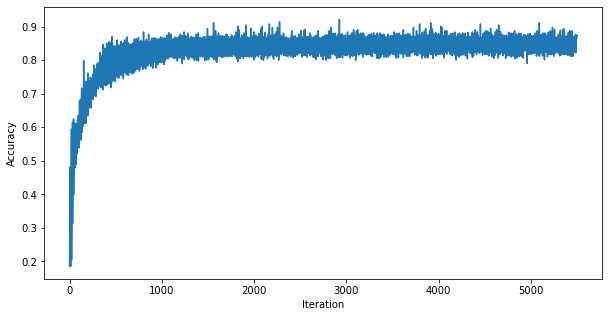

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

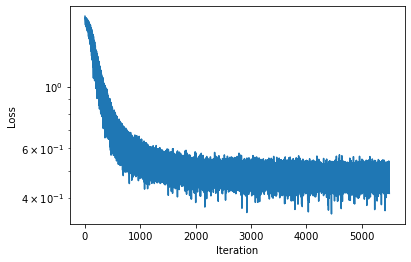

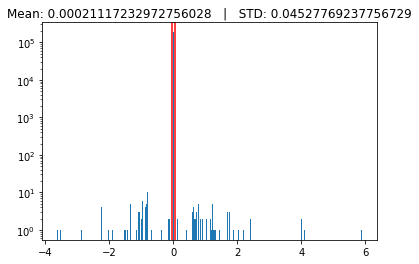

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 7.948275862068965


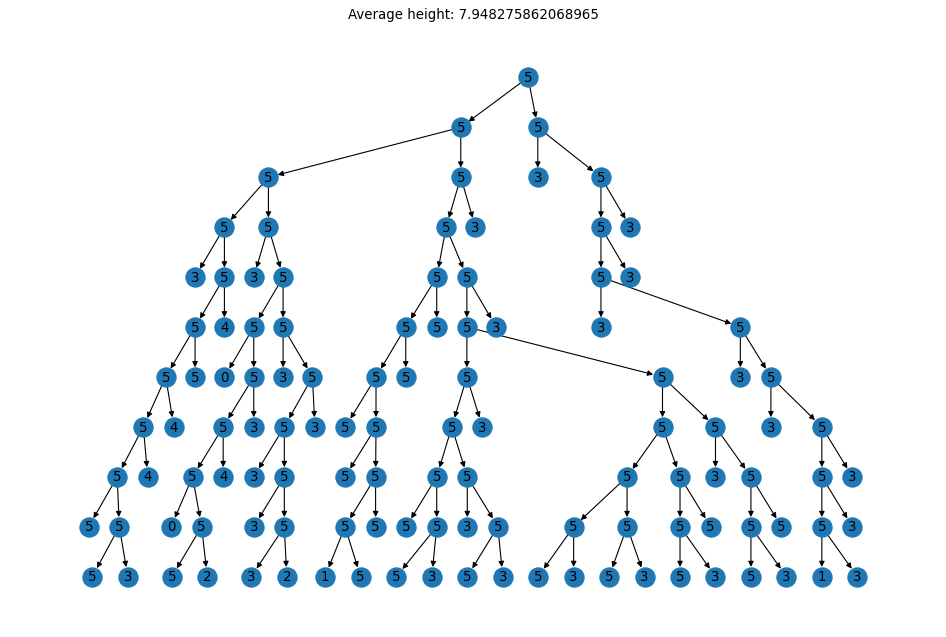

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 58


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
161
============== Pattern 2 ==============
1
============== Pattern 3 ==============
============== Pattern 4 ==============
186
============== Pattern 5 ==============
122
============== Pattern 6 ==============
449
============== Pattern 7 ==============
19374
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
=